In [10]:
from pathlib import Path
import shutil

import numpy as np
import pandas as pd
import geopandas as gpd

from shapely.geometry import box, Polygon
from shapely.affinity import translate
from shapely.strtree import STRtree
from shapely.ops import nearest_points, unary_union

from joblib import Parallel, delayed
from tqdm.notebook import tqdm
from pyrosm import OSM
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
import json
import random

from sklearn.neighbors import NearestNeighbors

# Notebook plotting defaults (optional)
plt.rcParams["figure.dpi"] = 300

In [11]:
# -------------------- CONFIG --------------------
PBF_PATH = "../data/input/koeln-regbez-250927.osm.pbf"
# (min_lon, min_lat, max_lon, max_lat) around Bonn
BBOX = [7.00, 50.65, 7.20, 50.82]

TARGET_CRS = "EPSG:25832"  # metric CRS (UTM 32N fits Bonn)
TILE_SIZE_M = 400          # tile width/height in meters
TOP_K = 824                # how many tiles to render

# figure → pixels (controls simplification tolerance)
FIG_INCH = 6
DPI = 300

DRAW_TILE_FRAME = True    # True to draw a thin outline around each tile

# filter road classes (keeps plot clean)
IMPORTANT_ROADS = {
    "motorway","trunk","primary","secondary","tertiary",
    "motorway_link","trunk_link","primary_link","secondary_link","tertiary_link",
    "residential","unclassified"
}
WIDTH_MAP = {
    "motorway": 2.0, "trunk": 1.8, "primary": 1.6,
    "secondary": 1.4, "tertiary": 1.2,
    "residential": 0.8, "unclassified": 0.8,
    "motorway_link": 1.4, "trunk_link": 1.3,
    "primary_link": 1.2, "secondary_link": 1.1, "tertiary_link": 1.0
}
# colors
ROAD_COLOR = "black"
BLDG_FACE = "gray"
BLDG_EDGE = "white"

# Reproducibility
SEED = 42

# Output folders
OUT_DIR = Path("../data/input/samples/metadata_new")

# NEW: root folder for the final samples layout
SAMPLES_DIR = Path("../data/input/samples/pairs_new")

summary_dir = Path("../data/input/samples/samples_summary_new")

RENDER_PNG = True

In [12]:
# -------------------- HELPERS --------------------
def make_grid(gdf, size):
    xmin, ymin, xmax, ymax = gdf.total_bounds
    xs = np.arange(xmin, xmax, size)
    ys = np.arange(ymin, ymax, size)
    polys = [box(x, y, x+size, y+size) for x in xs for y in ys]
    return gpd.GeoDataFrame({"tile_id": range(len(polys))}, geometry=polys, crs=gdf.crs)

def compute_tolerance(tile_size_m, fig_in, dpi):
    px = fig_in * dpi
    mpp = tile_size_m / px
    return mpp * 0.75  # safe simplification to pixel scale

def render_tile(tid, g_tile, tile_poly, roads_in_tiles, outdir, dpi, draw_tile_frame):
    fig, ax = plt.subplots(figsize=(FIG_INCH, FIG_INCH))
    ax.set_aspect("equal"); ax.set_axis_off()

    r_tile = roads_in_tiles[roads_in_tiles.tile_id == tid]
    if not r_tile.empty:
        if "highway" in r_tile.columns:
            for cls, df in r_tile.groupby("highway"):
                lw = WIDTH_MAP.get(cls, 0.8)
                df.plot(ax=ax, color=ROAD_COLOR, linewidth=lw, zorder=2)
        else:
            r_tile.plot(ax=ax, color=ROAD_COLOR, linewidth=0.9, zorder=2)

    g_tile.plot(ax=ax, facecolor=BLDG_FACE, edgecolor=BLDG_EDGE, linewidth=0.3, zorder=3)

    if draw_tile_frame:
        gpd.GeoSeries([tile_poly], crs=g_tile.crs).boundary.plot(
            ax=ax, color="lightgray", linewidth=0.5, zorder=1
        )

    xmin, ymin, xmax, ymax = tile_poly.bounds
    ax.set_xlim(xmin, xmax); ax.set_ylim(ymin, ymax)

    plt.savefig(outdir / f"{tid:04d}.png", dpi=dpi, bbox_inches="tight", pad_inches=0)
    plt.close(fig)

In [13]:
osm = OSM(PBF_PATH, bounding_box=BBOX)

buildings = osm.get_buildings()
roads = osm.get_network(network_type="all")  # try "driving" for fewer lines

print(f"Raw buildings: {0 if buildings is None else len(buildings)}")
print(f"Raw roads    : {0 if roads is None else len(roads)}")

if buildings is None or len(buildings) == 0:
    raise RuntimeError("No buildings found in this bbox.")

buildings = buildings.to_crs(TARGET_CRS)
if roads is not None and len(roads) > 0:
    roads = roads.to_crs(TARGET_CRS)

if roads is not None and len(roads) > 0 and "highway" in roads.columns:
    roads = roads[roads["highway"].isin(IMPORTANT_ROADS)].copy()

print("CRS:", buildings.crs, (None if roads is None else roads.crs))

/opt/anaconda3/envs/thesis/lib/python3.11/site-packages/shapely/constructive.py:246: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/anaconda3/envs/thesis/lib/python3.11/site-packages/shapely/constructive.py:246: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/anaconda3/envs/thesis/lib/python3.11/site-packages/pyrosm/networks.py:37: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a singl

Raw buildings: 188628
Raw roads    : 64576
CRS: EPSG:25832 EPSG:25832


In [14]:
grid = make_grid(buildings, size=TILE_SIZE_M)

b_cent = buildings.copy()
b_cent["geometry"] = b_cent.geometry.centroid
join = gpd.sjoin(b_cent, grid[["tile_id","geometry"]], how="left", predicate="within")
buildings["tile_id"] = join["tile_id"].values
buildings = buildings.dropna(subset=["tile_id"]).copy()
buildings["tile_id"] = buildings["tile_id"].astype(int)

counts = buildings.groupby("tile_id").size().rename("n_bldg")
top_ids = counts.nlargest(min(TOP_K, len(counts))).index

buildings_top = buildings[buildings["tile_id"].isin(top_ids)].copy()
grid_top = grid[grid["tile_id"].isin(top_ids)].copy()

counts.loc[top_ids].sort_values(ascending=False).head(10)

tile_id
520     789
858     745
906     731
1270    653
122     573
208     571
1367    569
288     567
1409    564
209     563
Name: n_bldg, dtype: int64

In [15]:
roads_in_tiles = gpd.GeoDataFrame(columns=["geometry","highway","tile_id"], crs=TARGET_CRS)
if roads is not None and len(roads) > 0:
    grid_pad = grid_top.copy()
    grid_pad["geometry"] = grid_pad.geometry.buffer(0.5)  # catch edge lines
    roads_in_tiles = gpd.sjoin(
        roads[["geometry","highway"]] if "highway" in roads.columns else roads[["geometry"]],
        grid_pad[["tile_id","geometry"]],
        how="inner", predicate="intersects"
    ).drop(columns="index_right")
    if "highway" not in roads_in_tiles.columns:
        roads_in_tiles["highway"] = None

# simplify to pixel scale
tol = compute_tolerance(TILE_SIZE_M, FIG_INCH, DPI)
buildings_top = buildings_top.set_geometry(buildings_top.geometry.simplify(tol, preserve_topology=True))
if len(roads_in_tiles) > 0:
    roads_in_tiles = roads_in_tiles.set_geometry(
        roads_in_tiles.geometry.simplify(tol*1.2, preserve_topology=True)
    )

tol

/opt/anaconda3/envs/thesis/lib/python3.11/site-packages/shapely/constructive.py:1177: RuntimeWarning: invalid value encountered in simplify_preserve_topology
  return lib.simplify_preserve_topology(geometry, tolerance, **kwargs)


0.16666666666666666

In [16]:
# Reproducibility
np.random.seed(SEED)
random.seed(SEED)


OUT_DIR.mkdir(parents=True, exist_ok=True)

if SAMPLES_DIR.exists():
    shutil.rmtree(SAMPLES_DIR)
SAMPLES_DIR.mkdir(parents=True, exist_ok=True)

In [17]:
# === DATA-DRIVEN PARAMETER BANDS (with optional shift for selection) ===
import numpy as np
import geopandas as gpd
from sklearn.neighbors import NearestNeighbors

g = buildings_top[["geometry"]].copy()
assert len(g) > 0, "No buildings in buildings_top."

# --- helper to make a [lo, hi] band around a center value with % width and clamps
def band(val, pct=0.20, lo=None, hi=None):
    a = float(val) * (1 - pct)
    b = float(val) * (1 + pct)
    if lo is not None: a = max(lo, a)
    if hi is not None: b = min(hi, b)
    if b <= a:
        b = a + (hi - lo) * 0.05 if (hi is not None and lo is not None) else a + 1e-6
    return (round(a, 3), round(b, 3))

# --- Areas for selection (m²)
areas = g.area
if len(areas) >= 5:
    A_low_q, A_med_q, A_high_q = np.quantile(areas, [0.10, 0.25, 0.40])
else:
    # fallbacks (sensible for urban buildings)
    A_low_q, A_med_q, A_high_q = 40.0, 80.0, 140.0

# --- Nearest-neighbor distances between centroids (meters)
cent = np.c_[g.geometry.centroid.x.values, g.geometry.centroid.y.values]
if len(cent) >= 2:
    nbrs = NearestNeighbors(n_neighbors=2).fit(cent)
    dists = np.sort(nbrs.kneighbors(cent, return_distance=True)[0][:, 1])
    D_low, D_med, D_high = np.quantile(dists, [0.25, 0.50, 0.75])
else:
    # fallbacks (dense-ish city)
    D_low, D_med, D_high = 2.0, 4.0, 7.0

print("Area quantiles (m²)  ~ 10/25/40%:", round(A_low_q,1), round(A_med_q,1), round(A_high_q,1))
print("NN distances (m)     ~ 25/50/75%:", round(D_low,2), round(D_med,2), round(D_high,2))

# --- Centers for each operator level (with sensible clamps)
# Aggregation buffer distance (m)
agg_low_c  = np.clip(max(2.0, D_low * 0.6),  2.0, 12.0)
agg_med_c  = np.clip(max(3.0, D_med * 1.0), 3.0, 12.0)
agg_high_c = np.clip(        D_high * 1.5,   4.0, 12.0)

# Displacement clearance (m)
disp_low_c  = np.clip(max(0.6, D_low * 0.3), 0.6, 3.0)
disp_med_c  = np.clip(max(1.2, D_med * 0.4), 1.0, 3.0)
disp_high_c = np.clip(        D_high * 0.6,  1.5, 3.0)

# Simplification epsilon (m) — tie to gap scale, but cap to avoid over-rounding
simp_low_c  = 0.5
simp_med_c  = min(3.0, max(1.0, D_low * 0.8))
simp_high_c = min(7.0, max(3.0, D_med * 1.0))

# --- Selection centers (m²), data-driven + configurable upward shift ----
# Choose ONE shift mode:
SHIFT_MODE = "add"   # "add" | "mul" | "pctile"

# (A) additive offsets in m²
SEL_ADD = {"low": 20.0, "medium": 50.0, "high": 90.0}
# (B) multiplicative factors
SEL_MUL = {"low": 1.25, "medium": 1.50, "high": 1.80}
# (C) alternate percentiles
ALT_Q = {"low": 0.20, "medium": 0.35, "high": 0.55}

# floors/ceilings for selection
SEL_MIN = {"low": 30.0, "medium": 70.0,  "high": 120.0}
SEL_MAX = {"low": 220.0, "medium": 260.0, "high": 320.0}

def shifted_selection_centers():
    if SHIFT_MODE == "add":
        c_low  = A_low_q  + SEL_ADD["low"]
        c_med  = A_med_q  + SEL_ADD["medium"]
        c_high = A_high_q + SEL_ADD["high"]
    elif SHIFT_MODE == "mul":
        c_low  = A_low_q  * SEL_MUL["low"]
        c_med  = A_med_q  * SEL_MUL["medium"]
        c_high = A_high_q * SEL_MUL["high"]
    elif SHIFT_MODE == "pctile":
        q_low, q_med, q_high = np.quantile(areas, [ALT_Q["low"], ALT_Q["medium"], ALT_Q["high"]])
        c_low, c_med, c_high = q_low, q_med, q_high
    else:
        raise ValueError("SHIFT_MODE must be 'add', 'mul', or 'pctile'")
    # clamp
    c_low  = float(np.clip(c_low,  SEL_MIN["low"],    SEL_MAX["low"]))
    c_med  = float(np.clip(c_med,  SEL_MIN["medium"], SEL_MAX["medium"]))
    c_high = float(np.clip(c_high, SEL_MIN["high"],   SEL_MAX["high"]))
    return c_low, c_med, c_high

sel_low_c, sel_med_c, sel_high_c = shifted_selection_centers()

# --- Build parameter ranges (±20%) with guardrails
PARAM_SCHEMES = {
    "aggregate": {
        "low":    band(agg_low_c,  pct=0.20, lo=2.0,  hi=12.0),
        "medium": band(agg_med_c,  pct=0.20, lo=3.0,  hi=12.0),
        "high":   band(agg_high_c, pct=0.20, lo=4.0,  hi=12.0),
        "unit": "m"
    },
    "simplify": {
        "low":    band(simp_low_c,  pct=0.20, lo=0.3, hi=2.0),
        "medium": band(simp_med_c,  pct=0.20, lo=1.0, hi=4.0),
        "high":   band(simp_high_c, pct=0.20, lo=3.0, hi=7.0),
        "unit": "m"
    },
    "displace": {
        "low":    band(disp_low_c,  pct=0.20, lo=0.5, hi=1.2),
        "medium": band(disp_med_c,  pct=0.20, lo=1.0, hi=2.0),
        "high":   band(disp_high_c, pct=0.20, lo=1.6, hi=3.0),
        "unit": "m"
    },
    "select": {
        "low":    band(sel_low_c,  pct=0.20, lo=SEL_MIN["low"],    hi=SEL_MAX["low"]),
        "medium": band(sel_med_c,  pct=0.20, lo=SEL_MIN["medium"], hi=SEL_MAX["medium"]),
        "high":   band(sel_high_c, pct=0.20, lo=SEL_MIN["high"],   hi=SEL_MAX["high"]),
        "unit": "m^2"
    }
}

# pretty print the bands you’ll sample from
print("\nAuto-tuned parameter bands:")
for op in ["aggregate", "simplify", "displace", "select"]:
    print(f"{op:10s}  low={PARAM_SCHEMES[op]['low']}  med={PARAM_SCHEMES[op]['medium']}  high={PARAM_SCHEMES[op]['high']}  ({PARAM_SCHEMES[op]['unit']})")

OPERATORS   = list(PARAM_SCHEMES.keys())
INTENSITIES = ["low", "medium", "high"]

def sample_param(op, intensity):
    lo, hi = PARAM_SCHEMES[op][intensity][:2]
    return float(np.random.uniform(lo, hi))

Area quantiles (m²)  ~ 10/25/40%: 17.4 28.2 60.9
NN distances (m)     ~ 25/50/75%: 5.75 7.79 12.12

Auto-tuned parameter bands:
aggregate   low=(2.759, 4.139)  med=(6.229, 9.343)  high=(9.6, 12.0)  (m)
simplify    low=(0.4, 0.6)  med=(2.4, 3.6)  high=(5.6, 7.0)  (m)
displace    low=(1.38, 1.415)  med=(2.4, 2.45)  high=(2.4, 3.0)  (m)
select      low=(30.0, 44.897)  med=(70.0, 93.883)  high=(120.707, 181.061)  (m^2)


In [18]:
# Expecting these to exist from your previous workflow:
# - buildings_top: polygons with a 'tile_id' column
# - grid_top: one polygon per tile_id

assert "tile_id" in buildings_top.columns, "buildings_top must have a 'tile_id' column"
assert "tile_id" in grid_top.columns, "grid_top must have a 'tile_id' column"

tile_ids = sorted(buildings_top["tile_id"].unique().tolist())
print(f"Tiles available: {len(tile_ids)}")
# Optional: ensure each tile has some buildings
counts = buildings_top.groupby("tile_id").size().sort_values(ascending=False)
counts.head(10)

Tiles available: 824


tile_id
520     789
858     745
906     731
1270    653
122     573
208     571
1367    569
288     567
1409    564
209     563
dtype: int64

In [19]:
def balanced_split(ids, groups):
    """Split list `ids` into len(groups) parts, sizes differ by at most 1."""
    n = len(ids); g = len(groups)
    base = n // g; rem = n % g
    parts = []
    start = 0
    for i in range(g):
        size = base + (1 if i < rem else 0)
        parts.append(ids[start:start+size])
        start += size
    return dict(zip(groups, parts))

ids_shuffled = tile_ids.copy()
random.shuffle(ids_shuffled)

# 1) split across operators
op_assign = balanced_split(ids_shuffled, OPERATORS)

# 2) within each operator, split across intensities
assignments = []  # list of dicts: {tile_id, operator, intensity, param}
for op, ids_for_op in op_assign.items():
    random.shuffle(ids_for_op)
    split_int = balanced_split(ids_for_op, INTENSITIES)
    for intensity, ids_for_int in split_int.items():
        for tid in ids_for_int:
            assignments.append({
                "tile_id": tid,
                "operator": op,
                "intensity": intensity,
                "param_value": sample_param(op, intensity),
                "param_unit": PARAM_SCHEMES[op]["unit"]
            })

assign_df = pd.DataFrame(assignments).sort_values(["operator","intensity","tile_id"]).reset_index(drop=True)
assign_df.head(12)

tile_id   operator intensity  param_value param_unit
0        73  aggregate      high    11.753318          m
1        78  aggregate      high    11.062954          m
2       126  aggregate      high    11.148415          m
3       141  aggregate      high    10.472711          m
4       212  aggregate      high    10.283617          m
5       215  aggregate      high    11.258251          m
6       258  aggregate      high    11.427887          m
7       286  aggregate      high    10.322108          m
8       361  aggregate      high    10.829023          m
9       390  aggregate      high     9.622073          m
10      454  aggregate      high    11.347719          m
11      455  aggregate      high    11.753065          m

In [20]:
def aggregate_buildings(gdf, dist, join_style=2, mitre_limit=5.0, cap_style=2, resolution=1):
    """
    Buffer(+dist) → dissolve → buffer(-dist) with straight (mitre) corners.
    join_style=2 (mitre), cap_style=2 (flat), small resolution for fewer arcs.
    """
    if gdf.empty:
        return gdf.copy()
    # dissolve via unary_union
    buff = gdf.geometry.buffer(dist,
                               join_style=join_style,
                               mitre_limit=mitre_limit,
                               cap_style=cap_style,
                               resolution=resolution)
    merged = unary_union(buff)
    # handle MultiPolygon/Polygon cases
    out = gpd.GeoDataFrame(geometry=[merged], crs=gdf.crs)
    out["geometry"] = out.geometry.buffer(-dist,
                                          join_style=join_style,
                                          mitre_limit=mitre_limit,
                                          cap_style=cap_style,
                                          resolution=resolution)
    # keep valid and non-empty
    out = out[~out.geometry.is_empty & out.geometry.is_valid]
    # explode again to individual polygons (blocks)
    out = out[~out.geometry.is_empty & out.geometry.is_valid]
    return out.explode(index_parts=False).reset_index(drop=True)

def simplify_buildings(gdf, eps):
    """Douglas–Peucker simplification on polygon boundaries."""
    if gdf.empty:
        return gdf.copy()
    out = gdf.copy()
    out["geometry"] = out.geometry.simplify(eps, preserve_topology=True)
    out = out[~out.geometry.is_empty & out.geometry.is_valid]
    return out

def _pairwise_push(vecs, clearance, step=0.5):
    """Compute displacement vectors for points so that pairwise distances >= clearance."""
    # vecs: (n,2) points
    n = len(vecs)
    disp = np.zeros_like(vecs, dtype=float)
    for i in range(n):
        # vector from others to i
        diffs = vecs[i] - vecs
        d2 = np.sum(diffs**2, axis=1)
        mask = (d2 > 0) & (d2 < clearance**2)
        if not np.any(mask):
            continue
        d = np.sqrt(d2[mask]).reshape(-1,1)
        push_dir = diffs[mask] / (d + 1e-6)
        strength = (clearance - d)  # stronger when closer
        v = np.sum(push_dir * strength, axis=0)
        # limit step
        nrm = np.linalg.norm(v)
        if nrm > 0:
            v = (v / nrm) * min(step, nrm)
        disp[i] += v
    return disp

def displace_buildings(gdf, clearance, iters=40, step=1.2, max_total=10.0, small_moves_more=True, area_ref=120.0):
    """
    Edge-aware repulsion with visible effect:
      • neighbors found via STRtree within 'clearance' buffer
      • push along nearest-edge direction (not centroid line)
      • more iterations + bigger step + higher max_total
      • (optional) small buildings move more (area weighting)

    Params
    ------
    clearance : float (m)  target min edge-to-edge spacing
    iters     : int        number of relaxation iterations
    step      : float (m)  max move per iteration
    max_total : float (m)  cap on total displacement
    small_moves_more : bool  if True, weight pushes so small polygons move more
    area_ref  : float (m²) reference area; weight = (area_ref / area) clipped to [0.5, 3]
    """
    if gdf.empty:
        return gdf.copy()

    out = gdf.copy()
    geoms = list(out.geometry.values)
    areas = np.maximum(1.0, np.array([g.area for g in geoms]))

    # weight: small buildings move more; large ones are stiffer
    if small_moves_more:
        w = (area_ref / areas)
        w = np.clip(w, 0.5, 3.0)    # don’t explode weights
    else:
        w = np.ones_like(areas)

    tree  = STRtree(geoms)

    # current offsets
    offsets = np.zeros((len(geoms), 2), dtype=float)

    for _ in range(iters):
        moved = np.zeros_like(offsets)
        any_push = False

        for i, gi in enumerate(geoms):
            # search potential neighbors within 'clearance' halo
            cand_idx = [j for j in tree.query(gi.buffer(clearance).envelope) if j != i]
            if not cand_idx:
                continue

            vi = np.array([0.0, 0.0])

            for j in cand_idx:
                gj = geoms[j]
                d = gi.distance(gj)
                if d >= clearance or d == 0:
                    continue

                # direction along closest-edge vector (gj -> gi)
                pi, pj = nearest_points(gi, gj)  # (on gi, on gj)
                dir_vec = np.array([pi.x - pj.x, pi.y - pj.y])
                nrm = np.linalg.norm(dir_vec)
                if nrm == 0:
                    continue
                dir_vec /= nrm

                deficit = clearance - d
                # share push; scale by weights (small moves more)
                push_i = 0.5 * deficit * (w[i] / (w[i] + w[j] + 1e-6))
                vi += dir_vec * push_i
                any_push = True

            # cap per-step move
            nrm = np.linalg.norm(vi)
            if nrm > 0:
                vi = (vi / nrm) * min(step, nrm)

            moved[i] = vi

        # accumulate & cap total motion
        offsets += moved
        norms = np.linalg.norm(offsets, axis=1)
        too_far = norms > max_total
        if np.any(too_far):
            scale = (max_total / (norms[too_far] + 1e-6)).reshape(-1,1)
            offsets[too_far] *= scale

        # apply this iteration’s movement
        geoms = [translate(g, xoff=float(dx), yoff=float(dy)) for g, (dx, dy) in zip(geoms, moved)]

        if not any_push or np.max(np.linalg.norm(moved, axis=1)) < 1e-3:
            break

    out["geometry"] = geoms
    out = out[~out.geometry.is_empty & out.geometry.is_valid]
    return out

def select_buildings(gdf, area_threshold):
    """Remove polygons smaller than area_threshold (m²)."""
    if gdf.empty:
        return gdf.copy()
    out = gdf.copy()
    areas = out.geometry.area
    out = out[areas >= area_threshold]
    return out

In [21]:
def render_single_frame(tid, gdf_buildings, tile_poly, roads_in_tiles, out_path):
    """Render one map frame (roads under buildings) with consistent style."""
    fig, ax = plt.subplots(figsize=(FIG_INCH, FIG_INCH))
    ax.set_aspect("equal"); ax.set_axis_off()

    # roads for this tile
    r_tile = roads_in_tiles[roads_in_tiles.tile_id == tid]
    if not r_tile.empty:
        if "highway" in r_tile.columns:
            for cls, df in r_tile.groupby("highway"):
                lw = WIDTH_MAP.get(cls, 0.8)
                df.plot(ax=ax, color=ROAD_COLOR, linewidth=lw, zorder=2)
        else:
            r_tile.plot(ax=ax, color=ROAD_COLOR, linewidth=0.9, zorder=2)

    # buildings on top with outlines so they don't "melt"
    if not gdf_buildings.empty:
        gdf_buildings.plot(ax=ax, facecolor=BLDG_FACE, edgecolor=BLDG_EDGE,
                           linewidth=0.3, zorder=3)

    # lock to tile extent for consistent framing
    xmin, ymin, xmax, ymax = tile_poly.bounds
    ax.set_xlim(xmin, xmax); ax.set_ylim(ymin, ymax)

    plt.savefig(out_path, dpi=DPI, bbox_inches="tight", pad_inches=0)
    plt.close(fig)

In [22]:
meta_rows = []

for _, row in assign_df.iterrows():
    tid      = int(row.tile_id)
    op       = row.operator
    inten    = row.intensity
    param_val= float(row.param_value)
    unit     = row.param_unit

    # per-sample folder (e.g., data/samples/0001/)
    sample_dir = SAMPLES_DIR / f"{tid:04d}"
    sample_dir.mkdir(parents=True, exist_ok=True)

    # grab the buildings for the tile and the tile polygon for framing
    g_tile   = buildings_top.loc[buildings_top.tile_id == tid][["geometry"]].copy()
    tile_poly= grid_top.loc[grid_top.tile_id == tid].geometry.iloc[0]

    # ----- save INPUT GeoJSON (if you still want it)
    in_geo_path = sample_dir / f"{tid:04d}_input.geojson"
    if not in_geo_path.exists():
        g_tile.to_file(in_geo_path, driver="GeoJSON")

    # ----- render INPUT PNG (consistent style)
    in_png_path = sample_dir / f"input_{tid:04d}.png"
    render_single_frame(tid, g_tile, tile_poly, roads_in_tiles, in_png_path)

    # ----- apply operator → generalized polygons
    if op == "aggregate":
        out_gdf = aggregate_buildings(g_tile, dist=param_val)
    elif op == "simplify":
        out_gdf = simplify_buildings(g_tile, eps=param_val)
    elif op == "displace":
        out_gdf = displace_buildings(g_tile, clearance=param_val, iters=15, step=0.6)
    elif op == "select":
        out_gdf = select_buildings(g_tile, area_threshold=param_val)
    else:
        raise ValueError(op)

    # ----- save TARGET GeoJSON
    out_geo_path = sample_dir / f"{tid:04d}_generalized.geojson"
    out_gdf.to_file(out_geo_path, driver="GeoJSON")

    # ----- render TARGET PNG with SAME style/colors/DPI
    out_png_path = sample_dir / f"generalized_{tid:04d}.png"
    render_single_frame(tid, out_gdf, tile_poly, roads_in_tiles, out_png_path)

    # ----- add metadata row
    meta_rows.append({
        "sample_id": tid,
        "operator": op,
        "intensity": inten,
        "param_value": round(param_val, 3),
        "param_unit": unit,
        "input_geojson": str(in_geo_path),
        "target_geojson": str(out_geo_path),
        "input_png": str(in_png_path),
        "target_png": str(out_png_path),
        "prompt": "",
        "notes": "",
        "n_input_polys": int(g_tile.shape[0]),
        "n_target_polys": int(out_gdf.shape[0]),
        "is_target_empty": bool(out_gdf.empty)
    })

/opt/anaconda3/envs/thesis/lib/python3.11/site-packages/shapely/constructive.py:246: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/anaconda3/envs/thesis/lib/python3.11/site-packages/shapely/set_operations.py:553: RuntimeWarning: invalid value encountered in unary_union
  return lib.unary_union(collections, **kwargs)
/opt/anaconda3/envs/thesis/lib/python3.11/site-packages/shapely/constructive.py:246: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/anaconda3/envs/thesis/lib/python3.11/site-packages/shapely/constructive.py:246: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/anaconda3/envs/thesis/lib/python3.11/site-packages/shapely/set_operations.py:553: RuntimeWarning: invalid value encountered in unary_union
  return lib.unary_union(collections, **kwargs)
/opt/anaconda3/envs/thesis/lib/python3.11/site-packages/shapely/constructive.py:246: RuntimeWarning: invalid value encountered in buffer
  ret

In [23]:
meta_df = pd.DataFrame(meta_rows)
meta_path = OUT_DIR / "meta.csv"
meta_df.to_csv(meta_path, index=False)
print("Saved:", meta_path)

# Quick quality checks
print("\nCounts by operator:")
display(meta_df["operator"].value_counts())

print("\nOperator × intensity:")
display(pd.crosstab(meta_df["operator"], meta_df["intensity"]))

print("\nEmpty targets (should be few or none):", meta_df["is_target_empty"].sum())
display(meta_df.head(10))

Saved: ../data/input/samples/metadata_new/meta.csv

Counts by operator:


operator
aggregate    206
displace     206
select       206
simplify     206
Name: count, dtype: int64


Operator × intensity:


intensity  high  low  medium
operator                    
aggregate    68   69      69
displace     68   69      69
select       68   69      69
simplify     68   69      69


Empty targets (should be few or none): 0


sample_id   operator intensity  param_value param_unit  \
0         73  aggregate      high       11.753          m   
1         78  aggregate      high       11.063          m   
2        126  aggregate      high       11.148          m   
3        141  aggregate      high       10.473          m   
4        212  aggregate      high       10.284          m   
5        215  aggregate      high       11.258          m   
6        258  aggregate      high       11.428          m   
7        286  aggregate      high       10.322          m   
8        361  aggregate      high       10.829          m   
9        390  aggregate      high        9.622          m   

                                       input_geojson  \
0  ../data/input/samples/pairs_new/0073/0073_inpu...   
1  ../data/input/samples/pairs_new/0078/0078_inpu...   
2  ../data/input/samples/pairs_new/0126/0126_inpu...   
3  ../data/input/samples/pairs_new/0141/0141_inpu...   
4  ../data/input/samples/pairs_new/0212/0212_inpu...   
5  ../data/input/samples/pairs_new/0215/0215_inpu...   
6  ../data/input/samples/pairs_new/0258/0258_inpu...   
7  ../data/input/samples/pairs_new/0286/0286_inpu...   
8  ../data/input/samples/pairs_new/0361/0361_inpu...   
9  ../data/input/samples/pairs_new/0390/0390_inpu...   

                                      target_geojson  \
0  ../data/input/samples/pairs_new/0073/0073_gene...   
1  ../data/input/samples/pairs_new/0078/0078_gene...   
2  ../data/input/samples/pairs_new/0126/0126_gene...   
3  ../data/input/samples/pairs_new/0141/0141_gene...   
4  ../data/input/samples/pairs_new/0212/0212_gene...   
5  ../data/input/samples/pairs_new/0215/0215_gene...   
6  ../data/input/samples/pairs_new/0258/0258_gene...   
7  ../data/input/samples/pairs_new/0286/0286_gene...   
8  ../data/input/samples/pairs_new/0361/0361_gene...   
9  ../data/input/samples/pairs_new/0390/0390_gene...   

                                           input_png  \
0  ../data/input/samples/pairs_new/0073/input_007...   
1  ../data/input/samples/pairs_new/0078/input_007...   
2  ../data/input/samples/pairs_new/0126/input_012...   
3  ../data/input/samples/pairs_new/0141/input_014...   
4  ../data/input/samples/pairs_new/0212/input_021...   
5  ../data/input/samples/pairs_new/0215/input_021...   
6  ../data/input/samples/pairs_new/0258/input_025...   
7  ../data/input/samples/pairs_new/0286/input_028...   
8  ../data/input/samples/pairs_new/0361/input_036...   
9  ../data/input/samples/pairs_new/0390/input_039...   

                                          target_png prompt notes  \
0  ../data/input/samples/pairs_new/0073/generaliz...                
1  ../data/input/samples/pairs_new/0078/generaliz...                
2  ../data/input/samples/pairs_new/0126/generaliz...                
3  ../data/input/samples/pairs_new/0141/generaliz...                
4  ../data/input/samples/pairs_new/0212/generaliz...                
5  ../data/input/samples/pairs_new/0215/generaliz...                
6  ../data/input/samples/pairs_new/0258/generaliz...                
7  ../data/input/samples/pairs_new/0286/generaliz...                
8  ../data/input/samples/pairs_new/0361/generaliz...                
9  ../data/input/samples/pairs_new/0390/generaliz...                

   n_input_polys  n_target_polys  is_target_empty  
0            381               4            False  
1            208              17            False  
2            119               8            False  
3            239              13            False  
4             87              17            False  
5            272               6            False  
6            131              16            False  
7            326              19            False  
8            163              16            False  
9            441              15            False

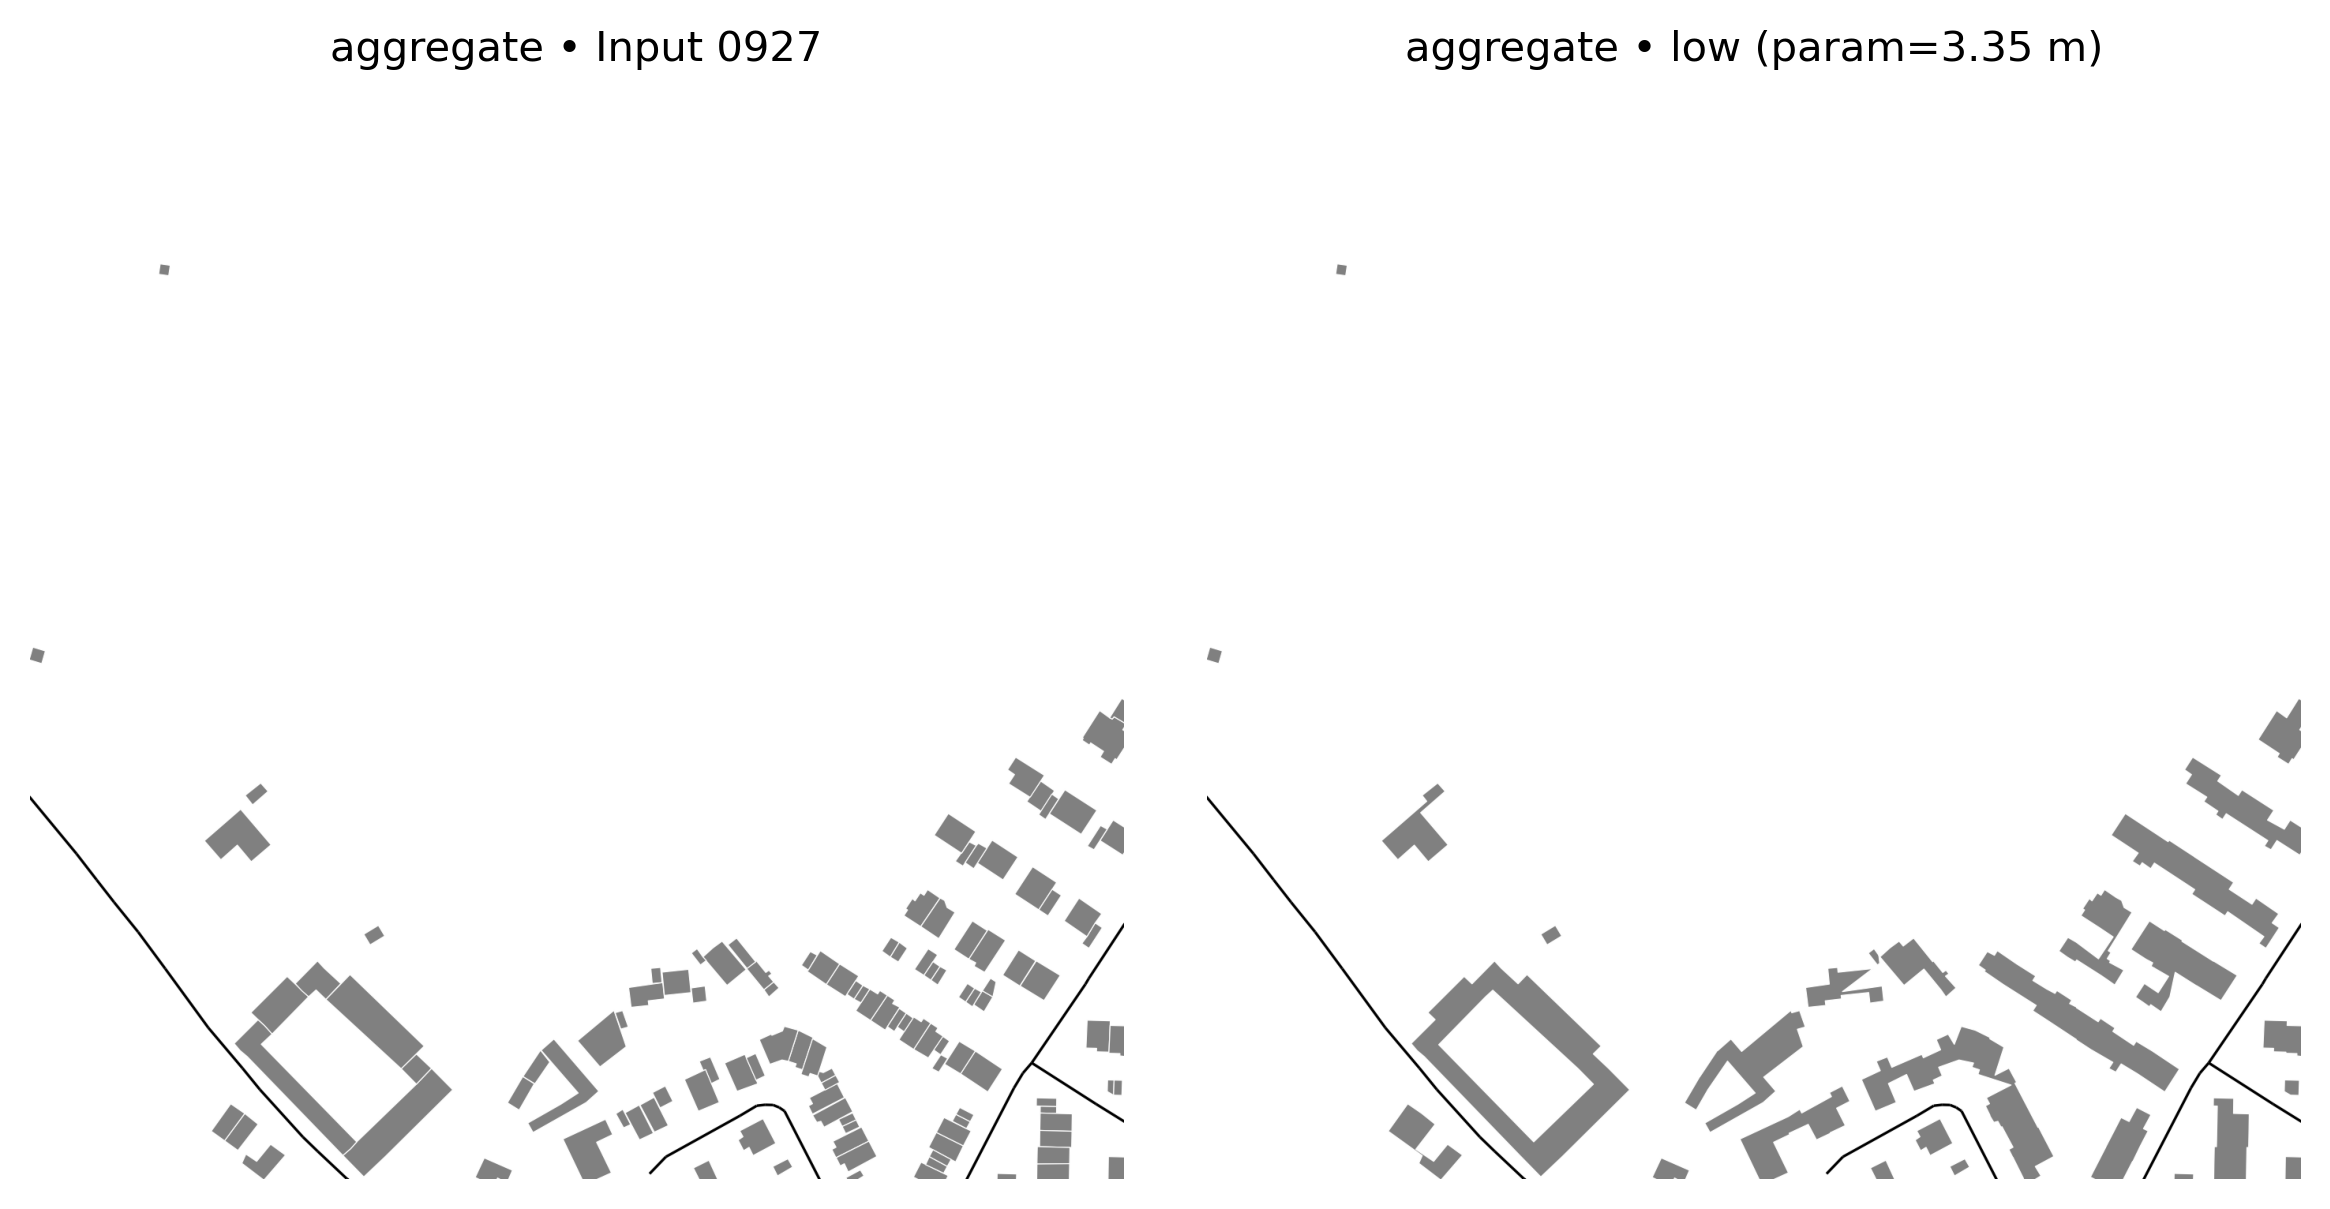

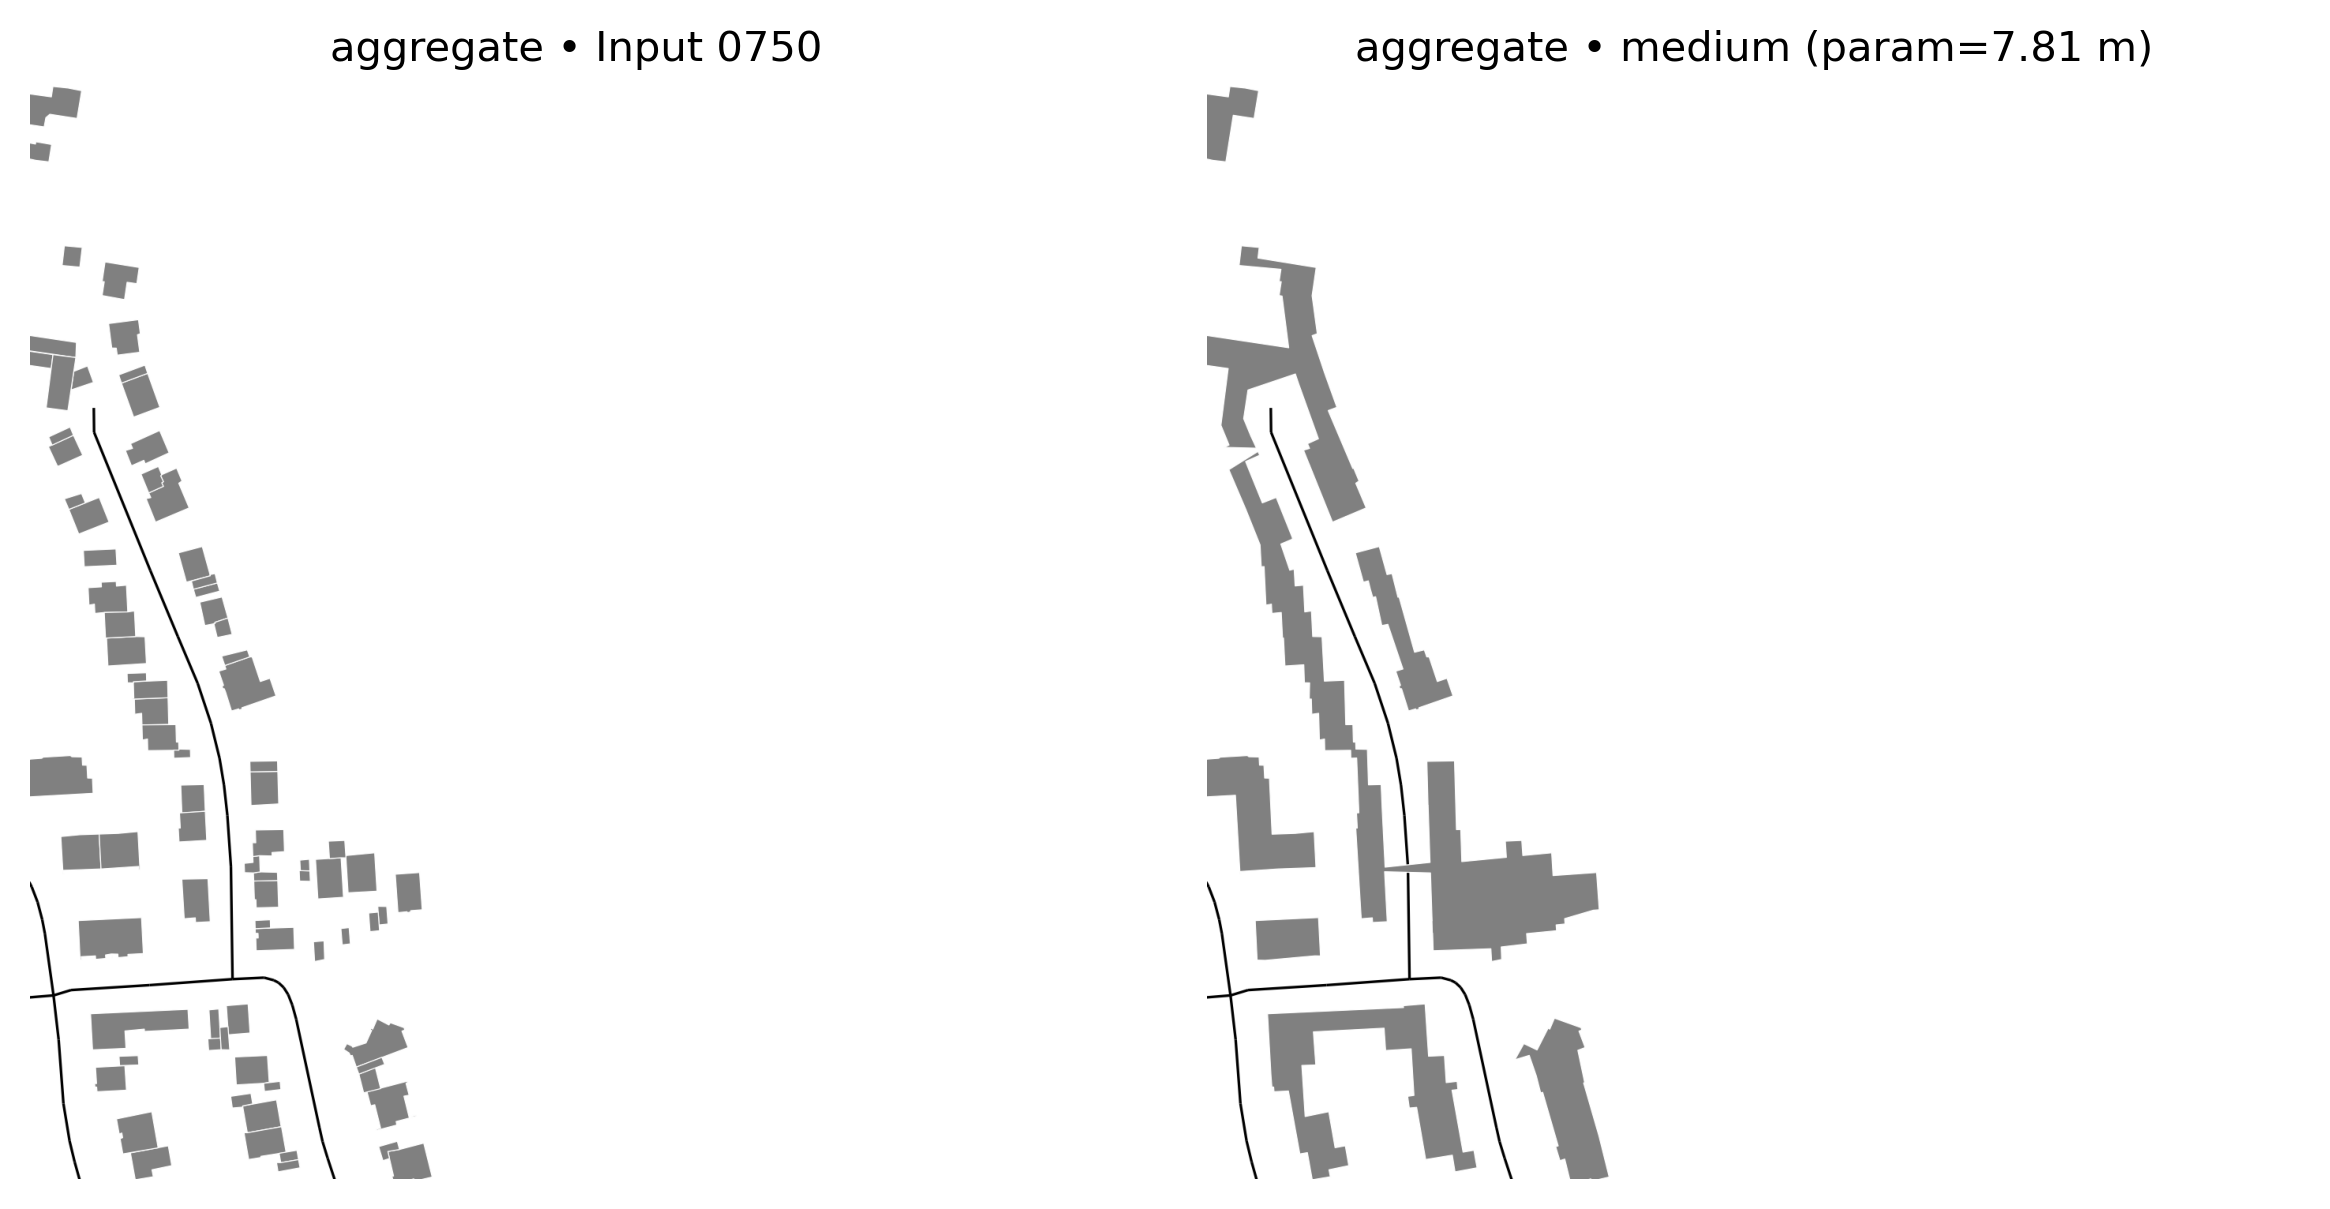

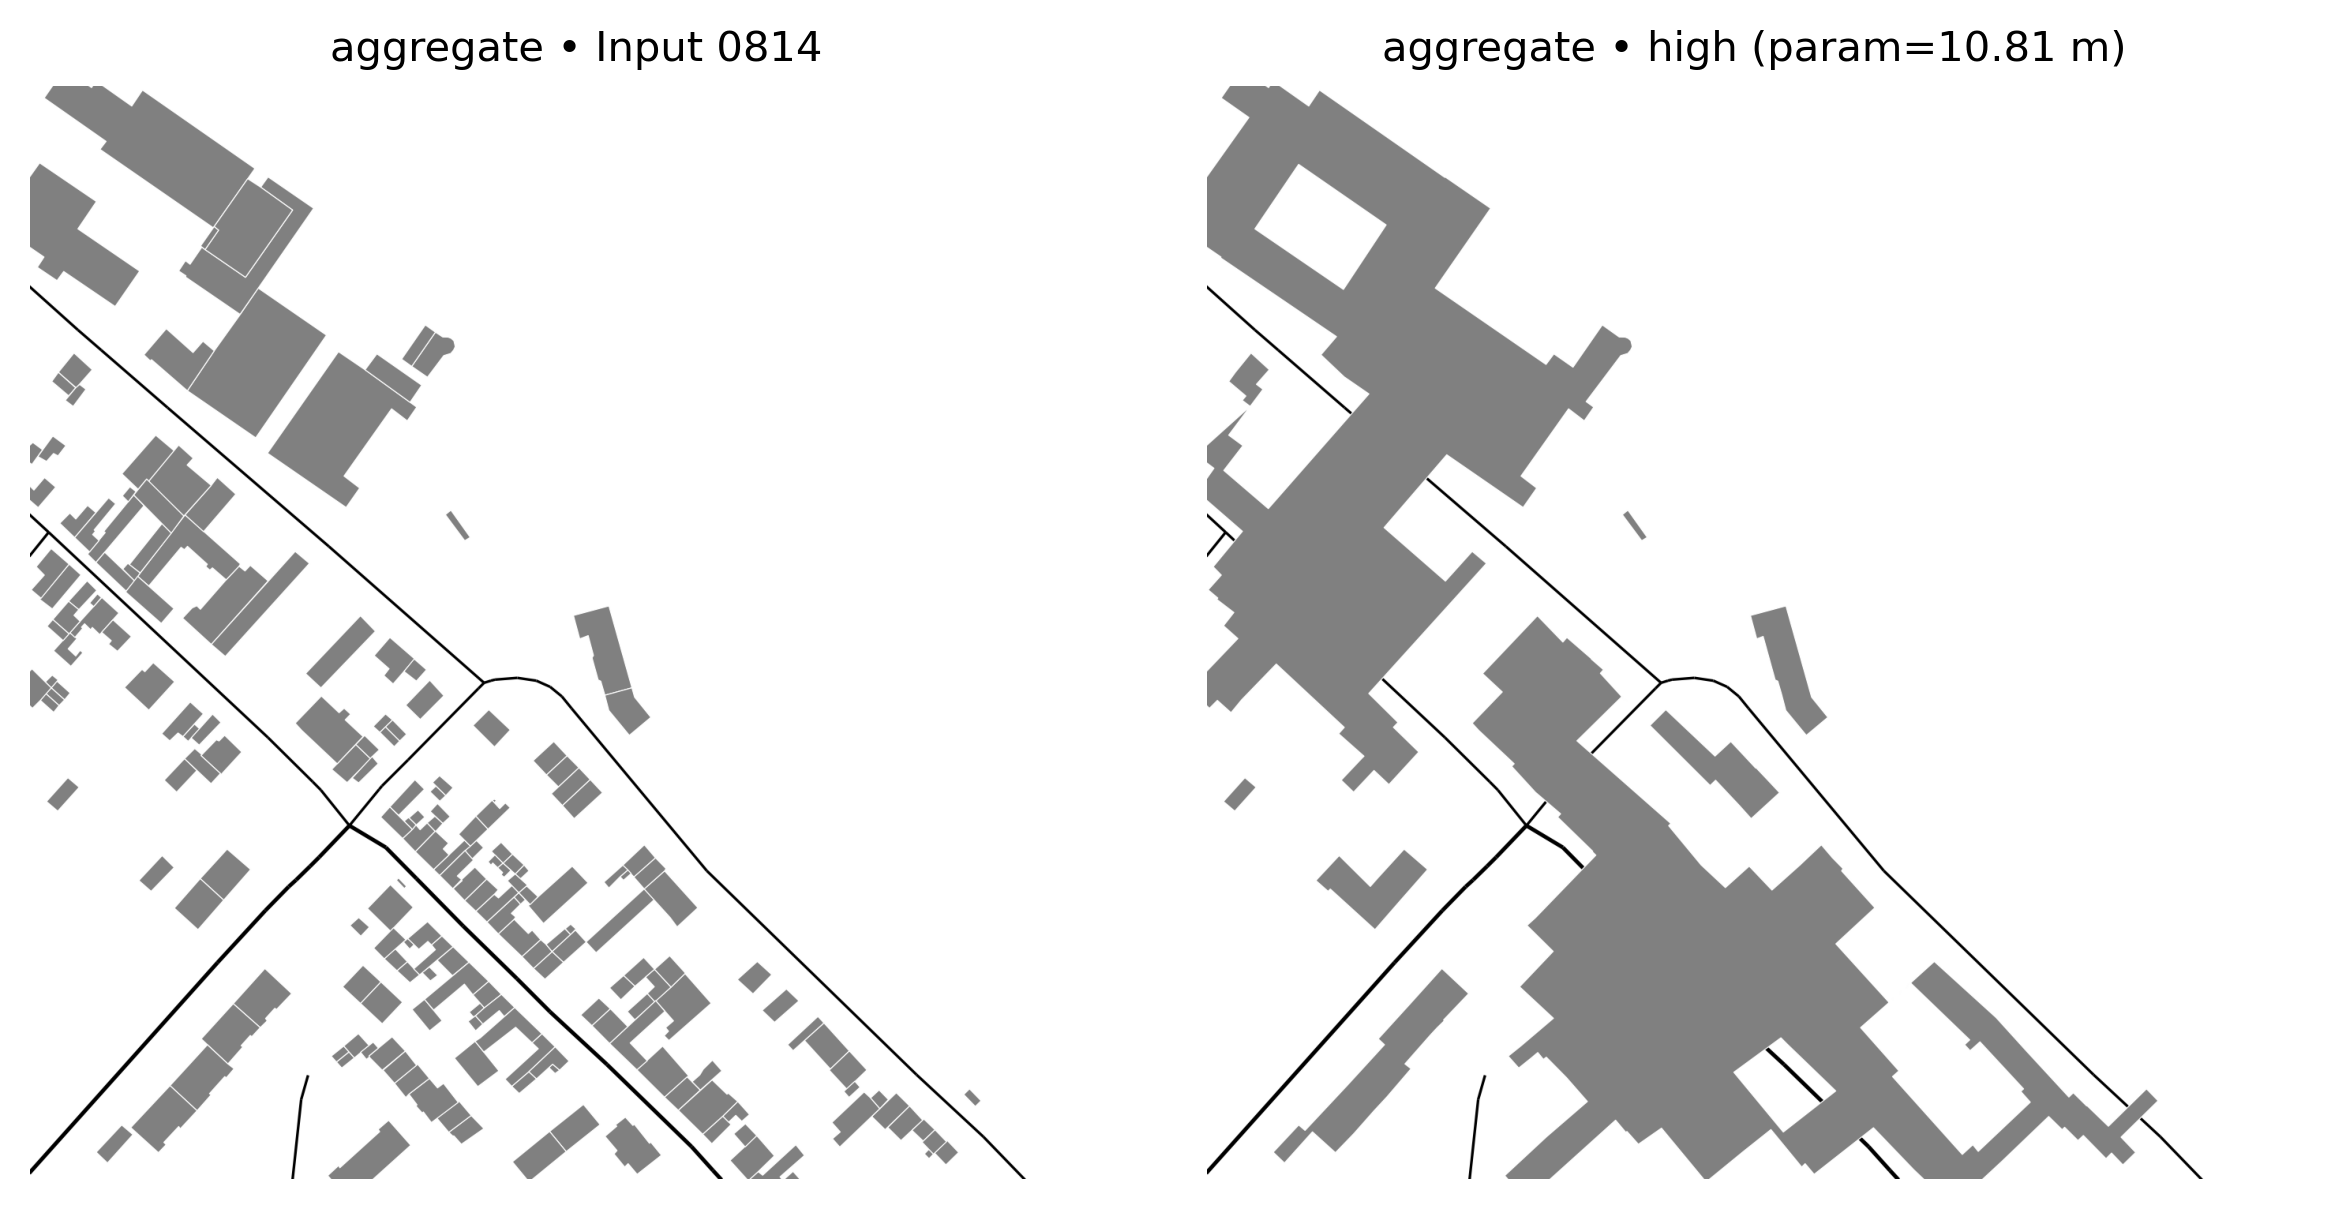

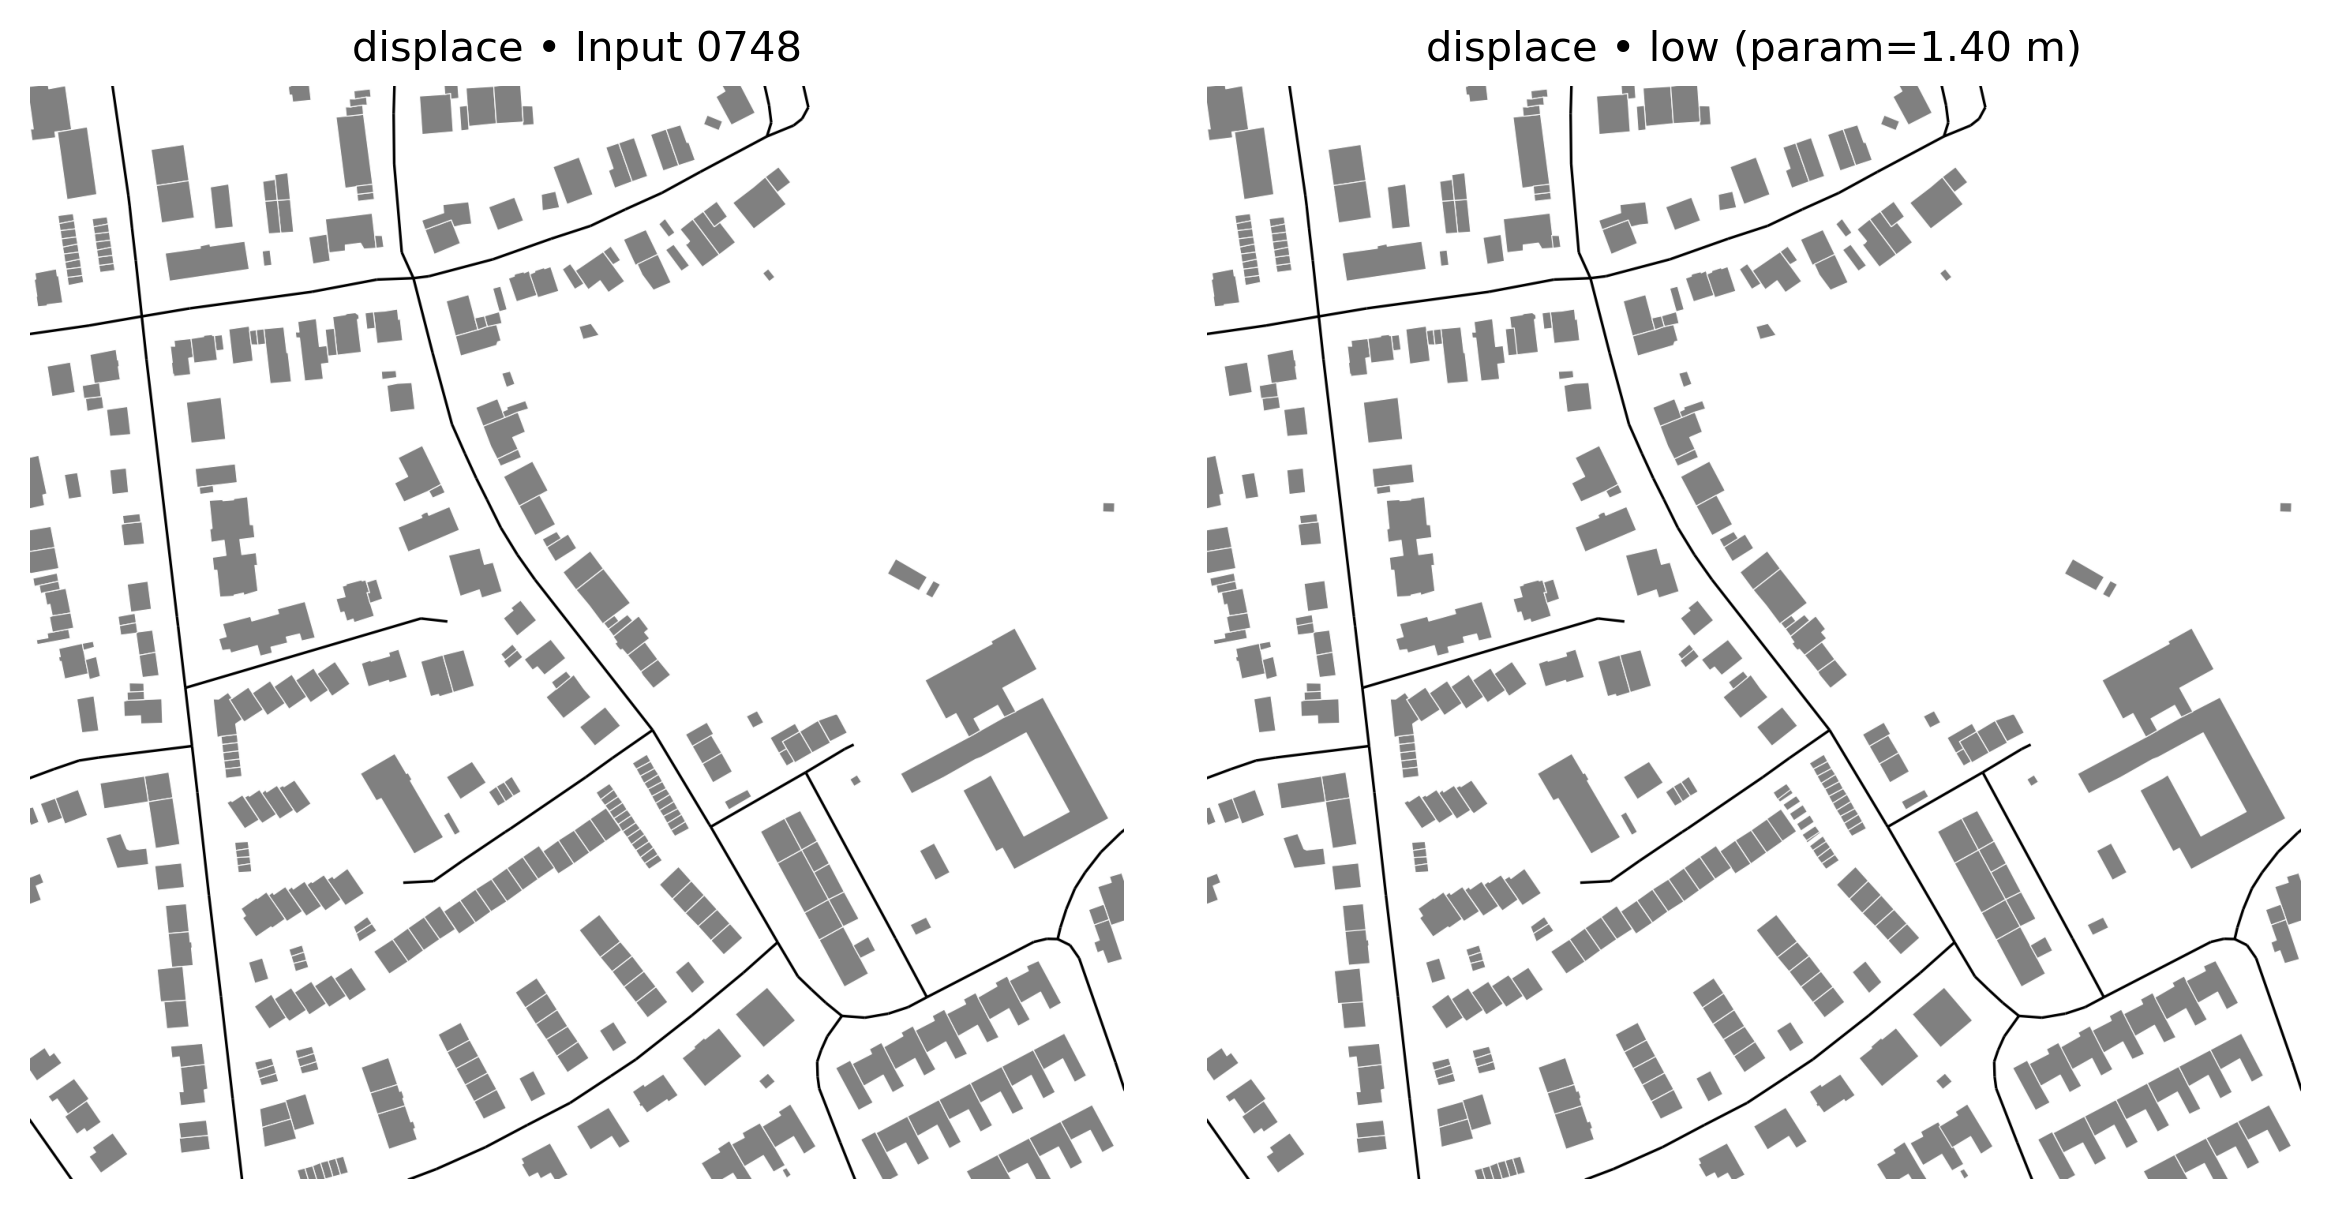

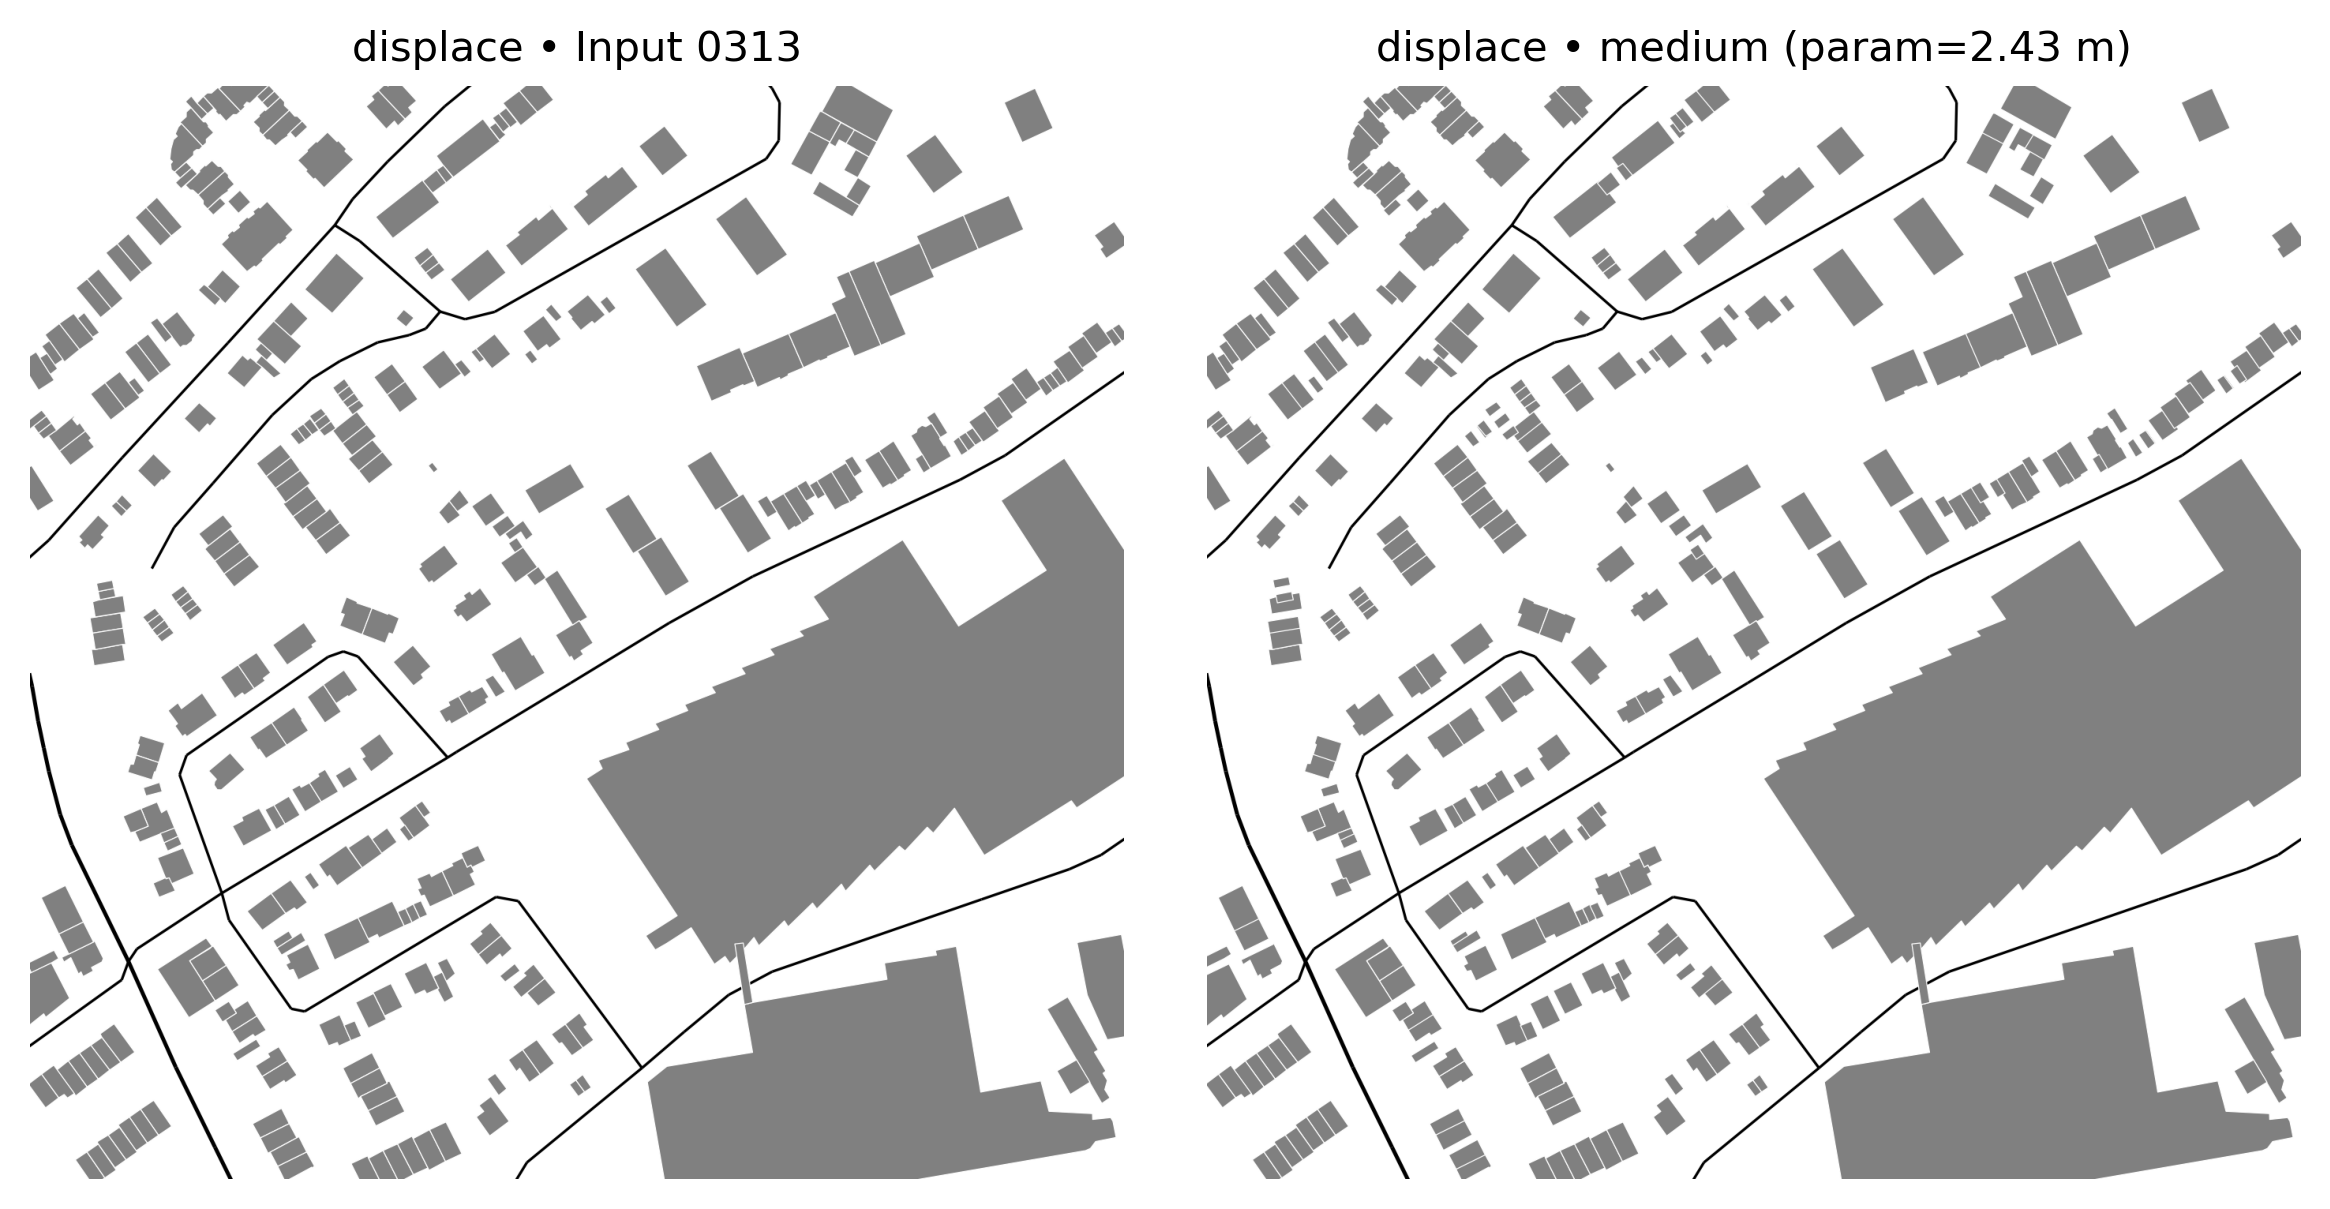

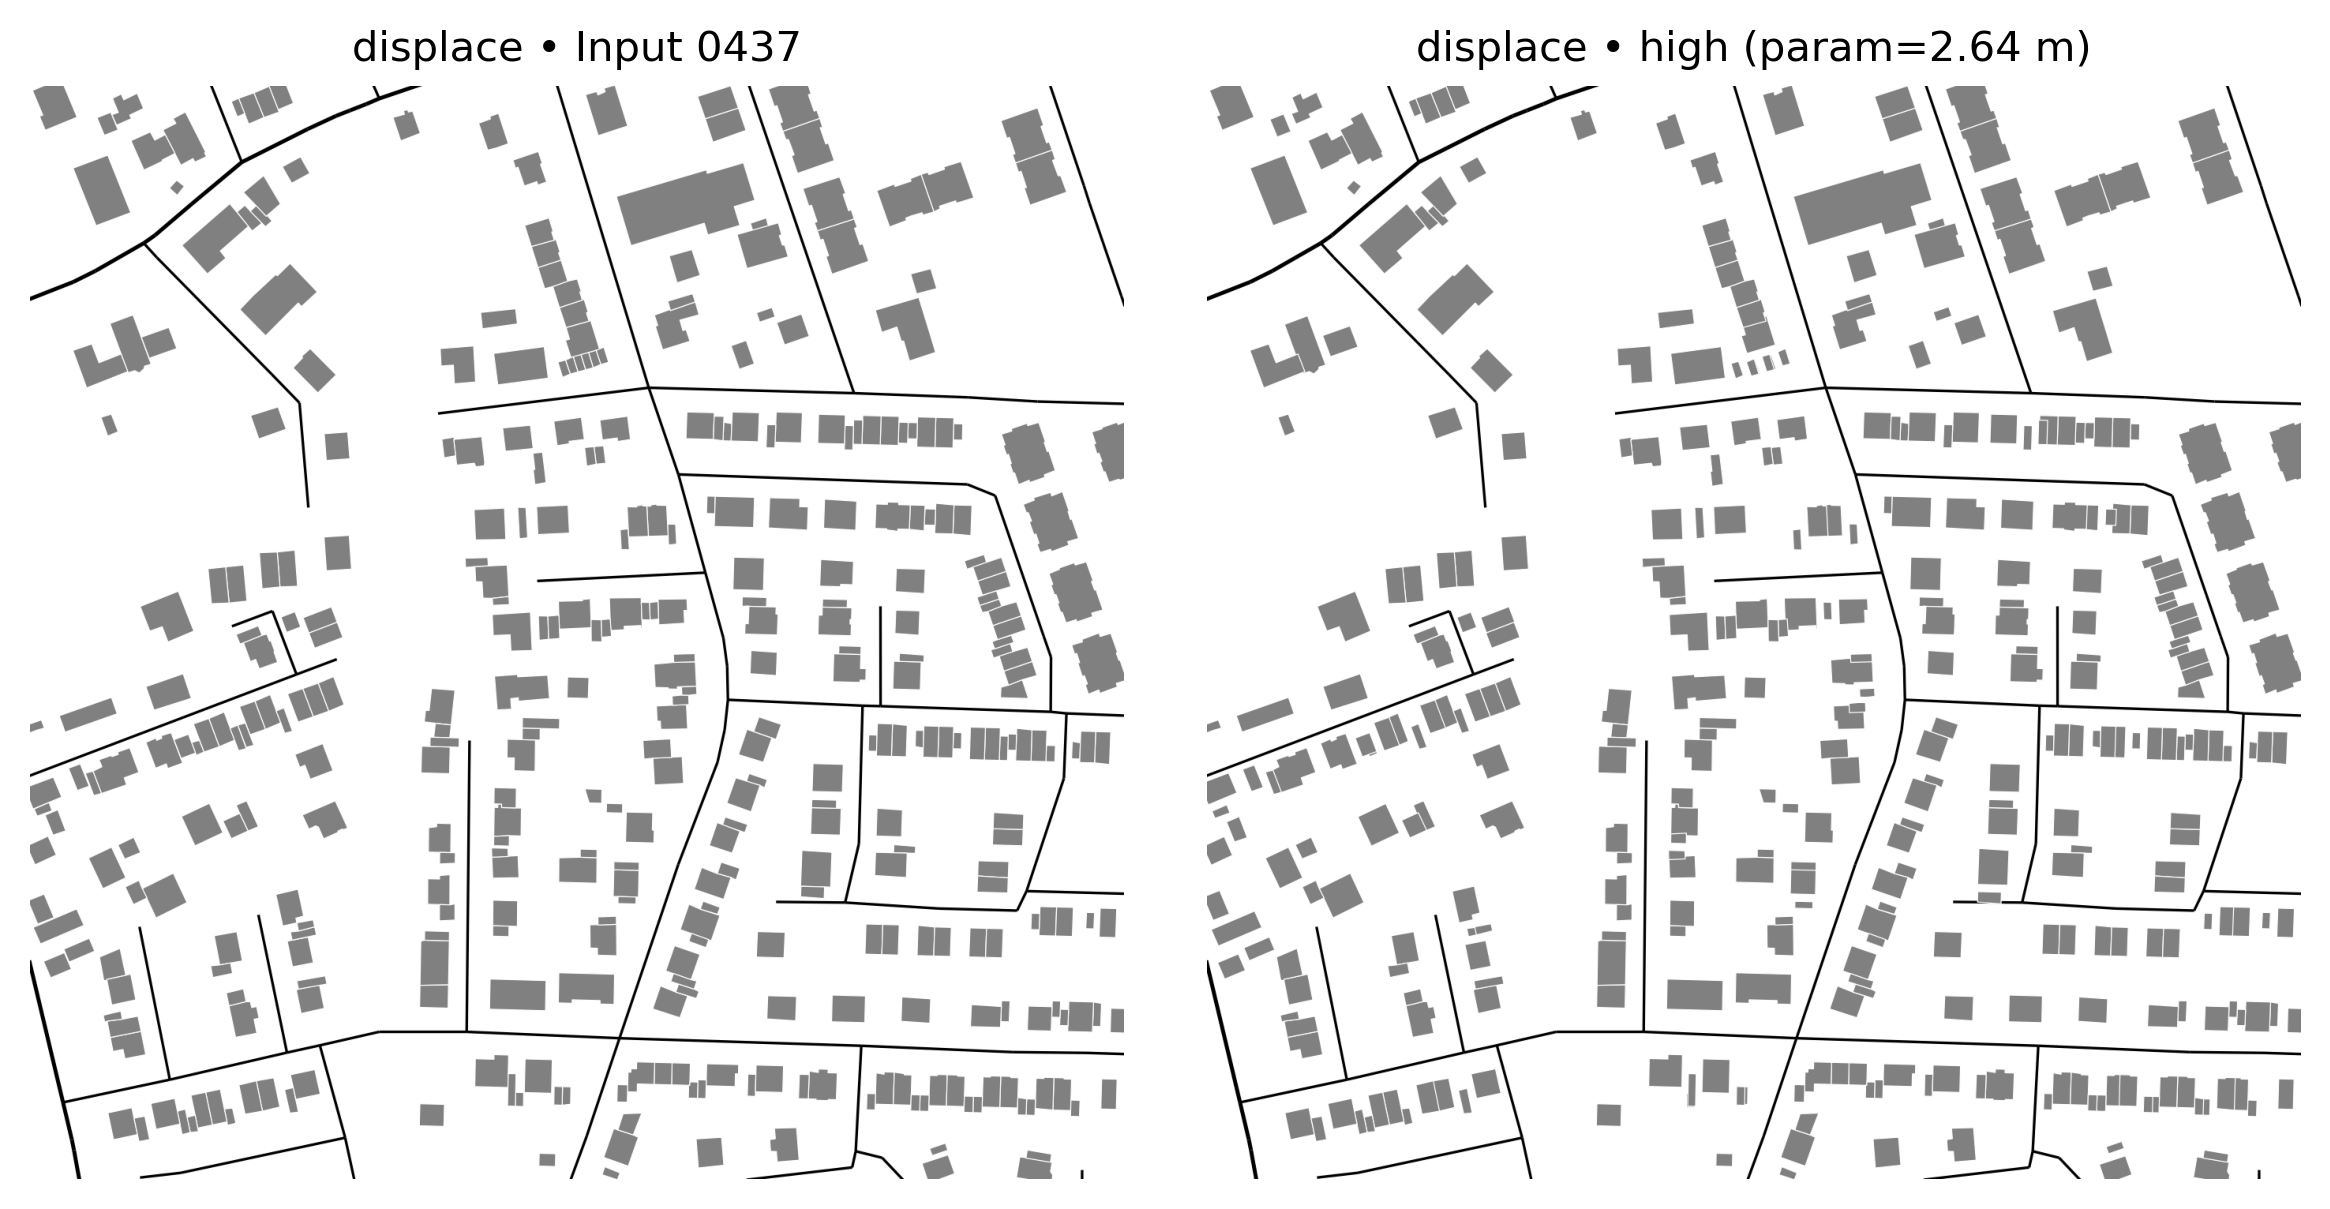

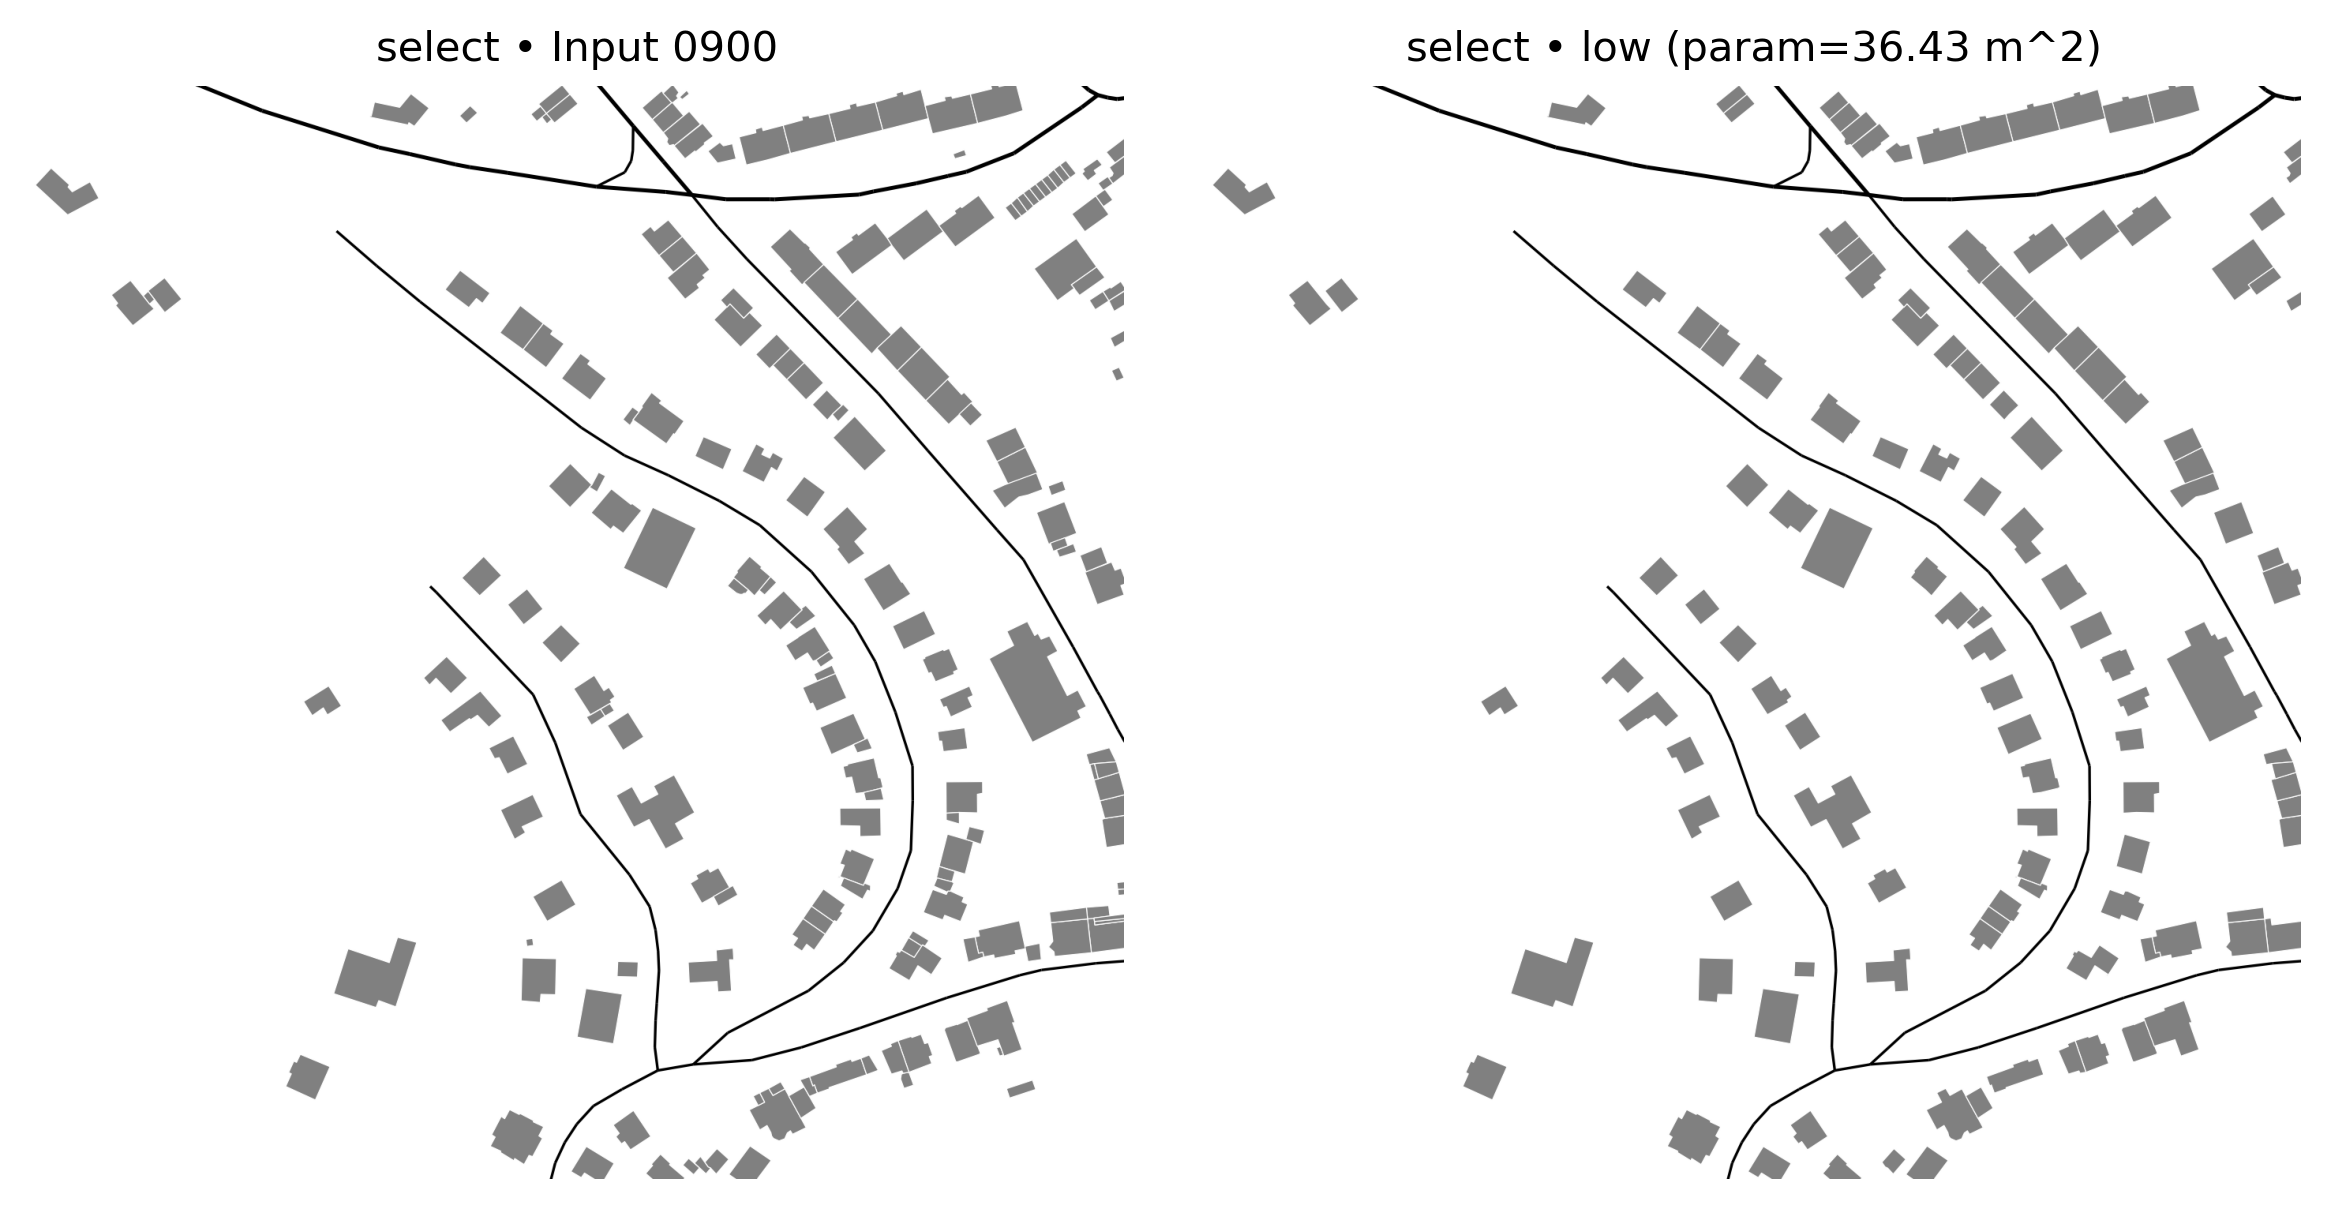

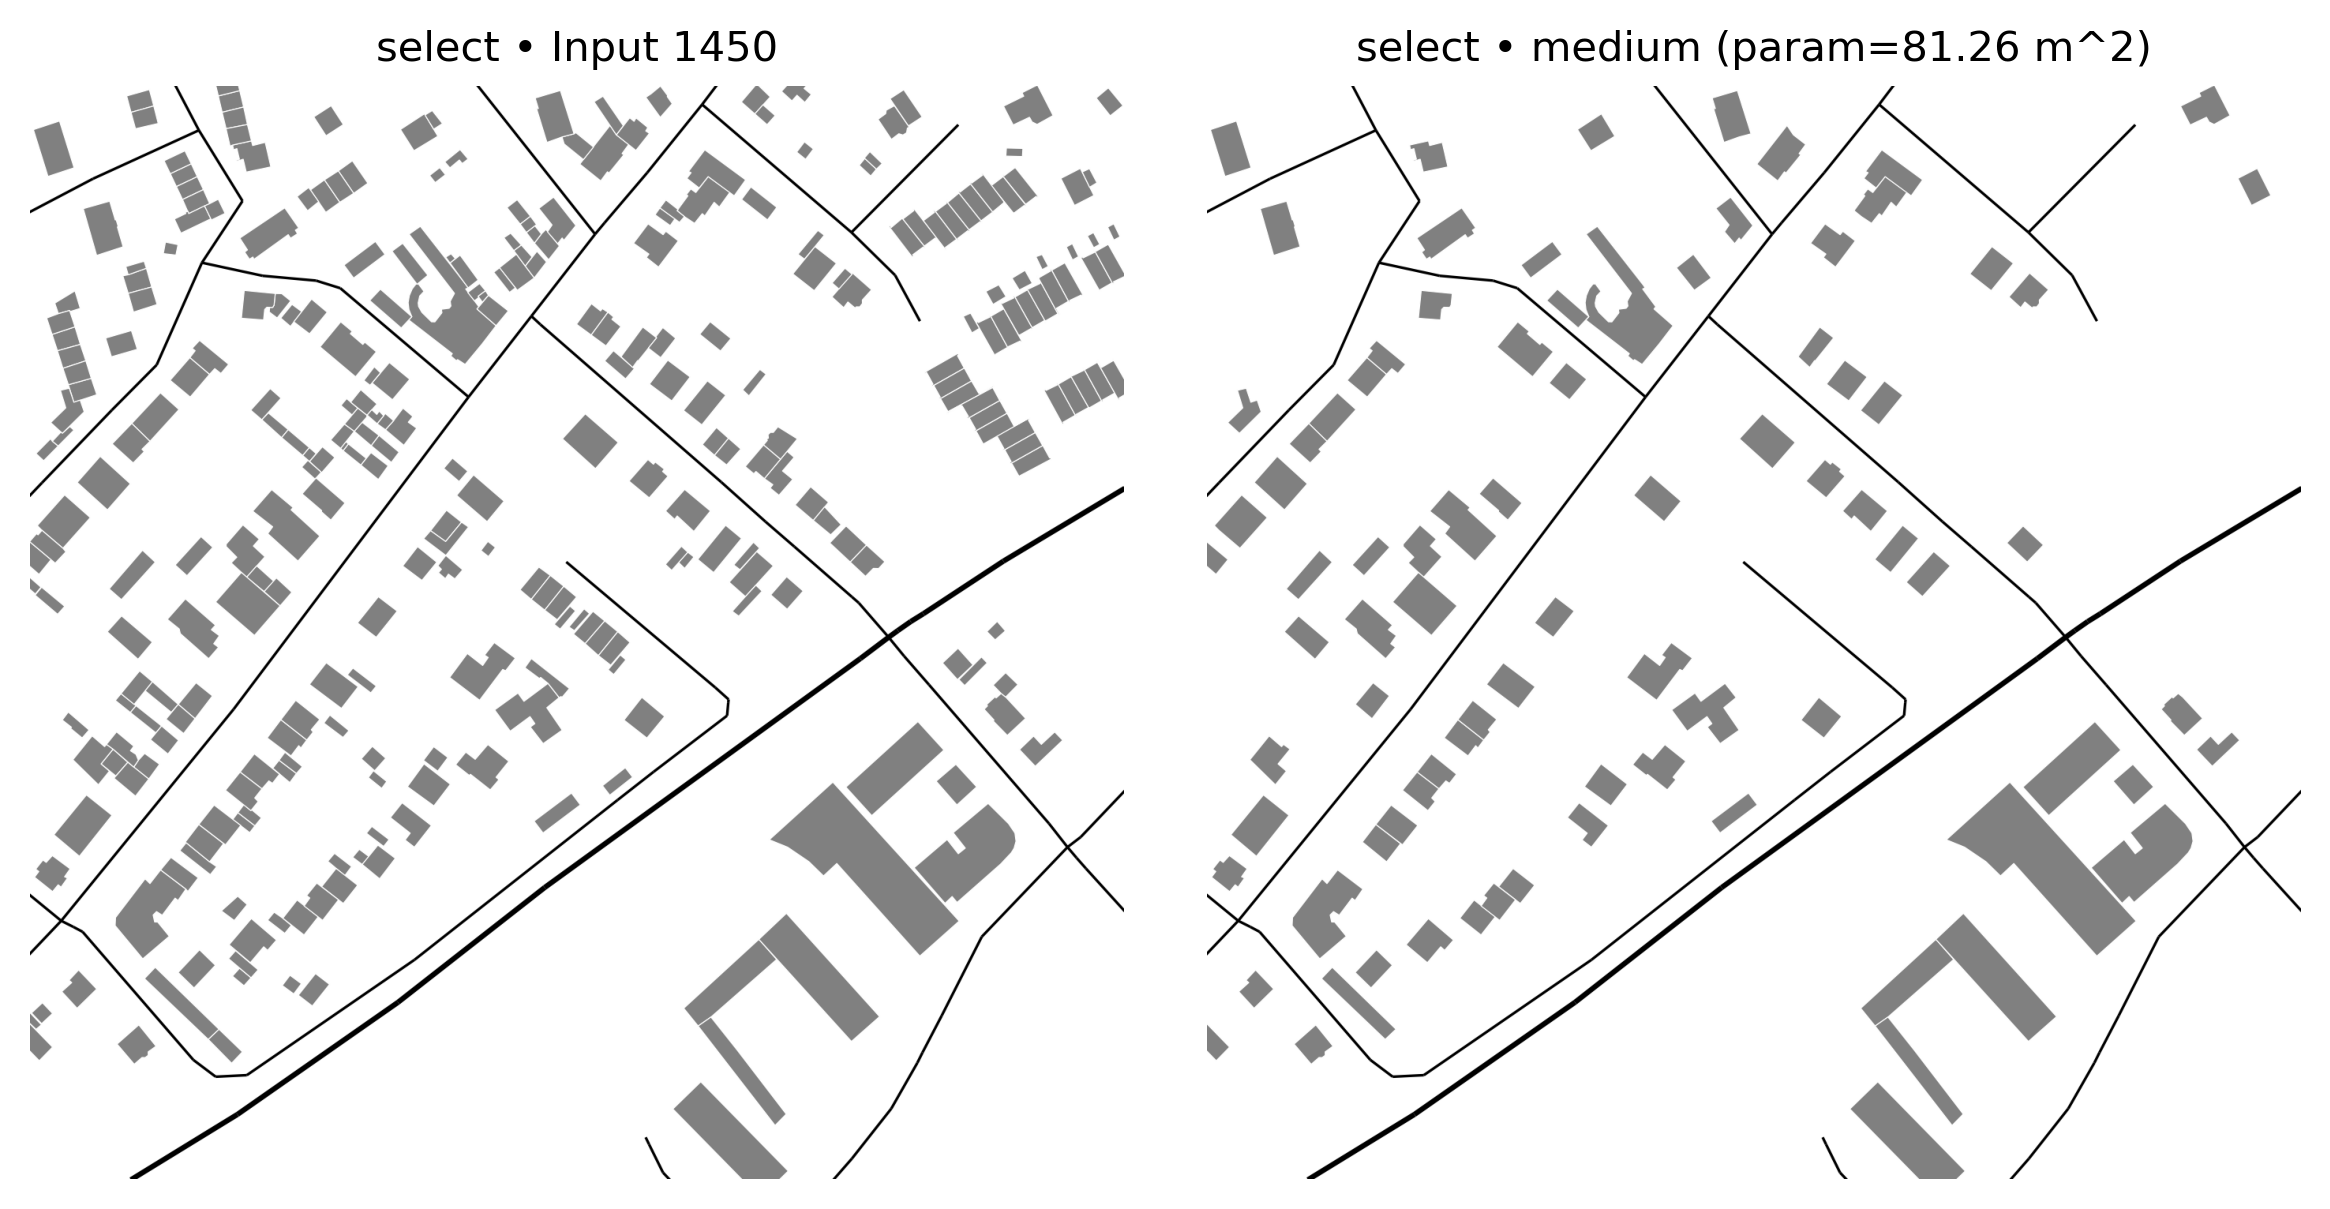

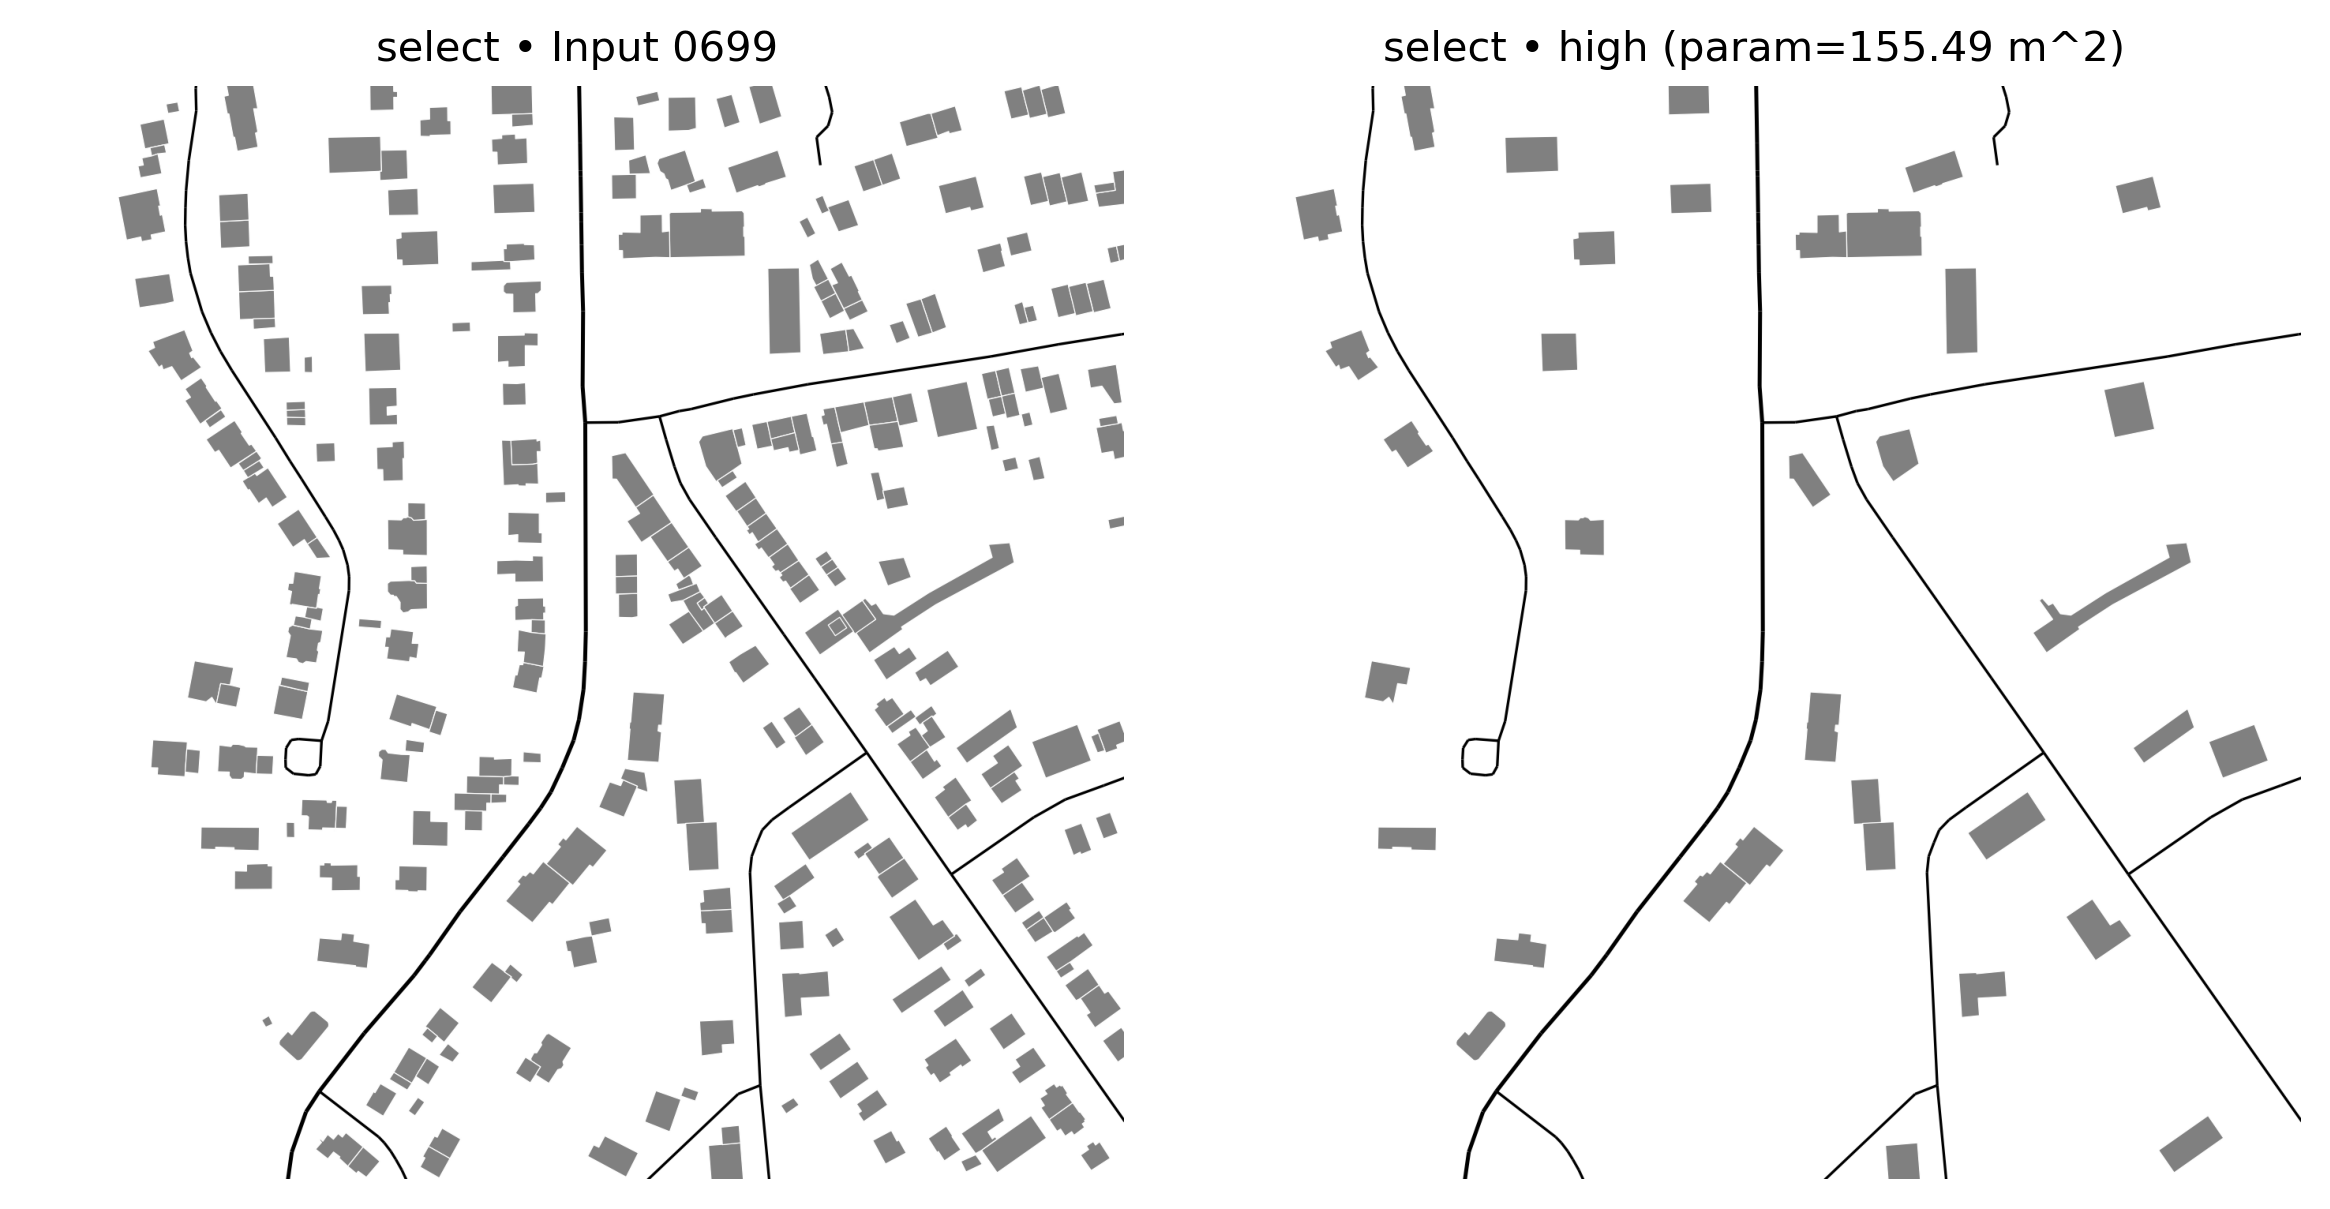

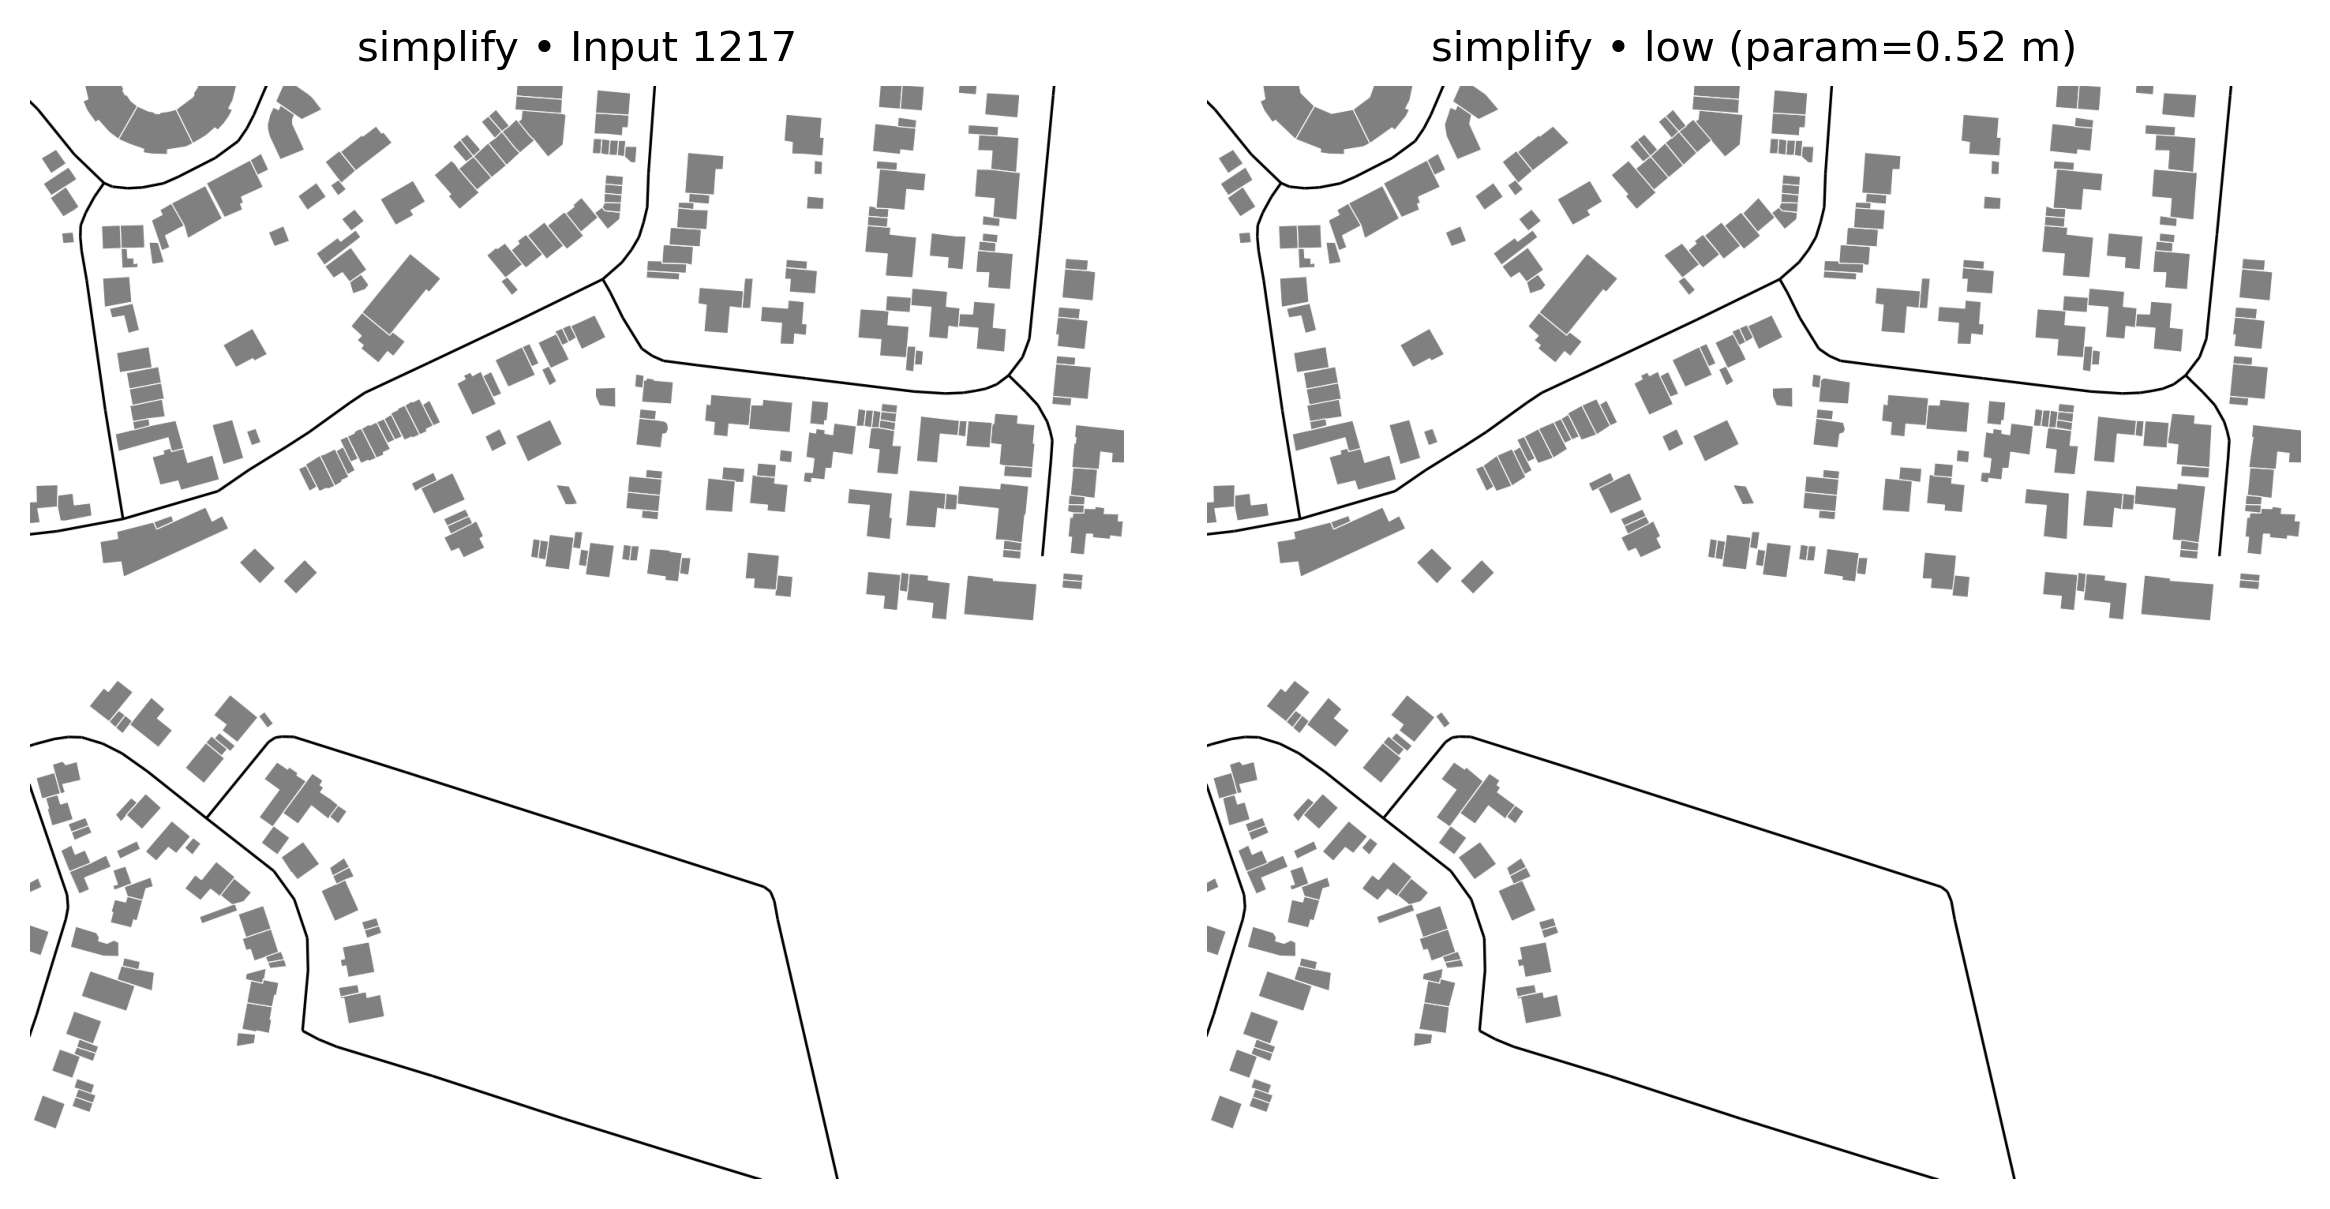

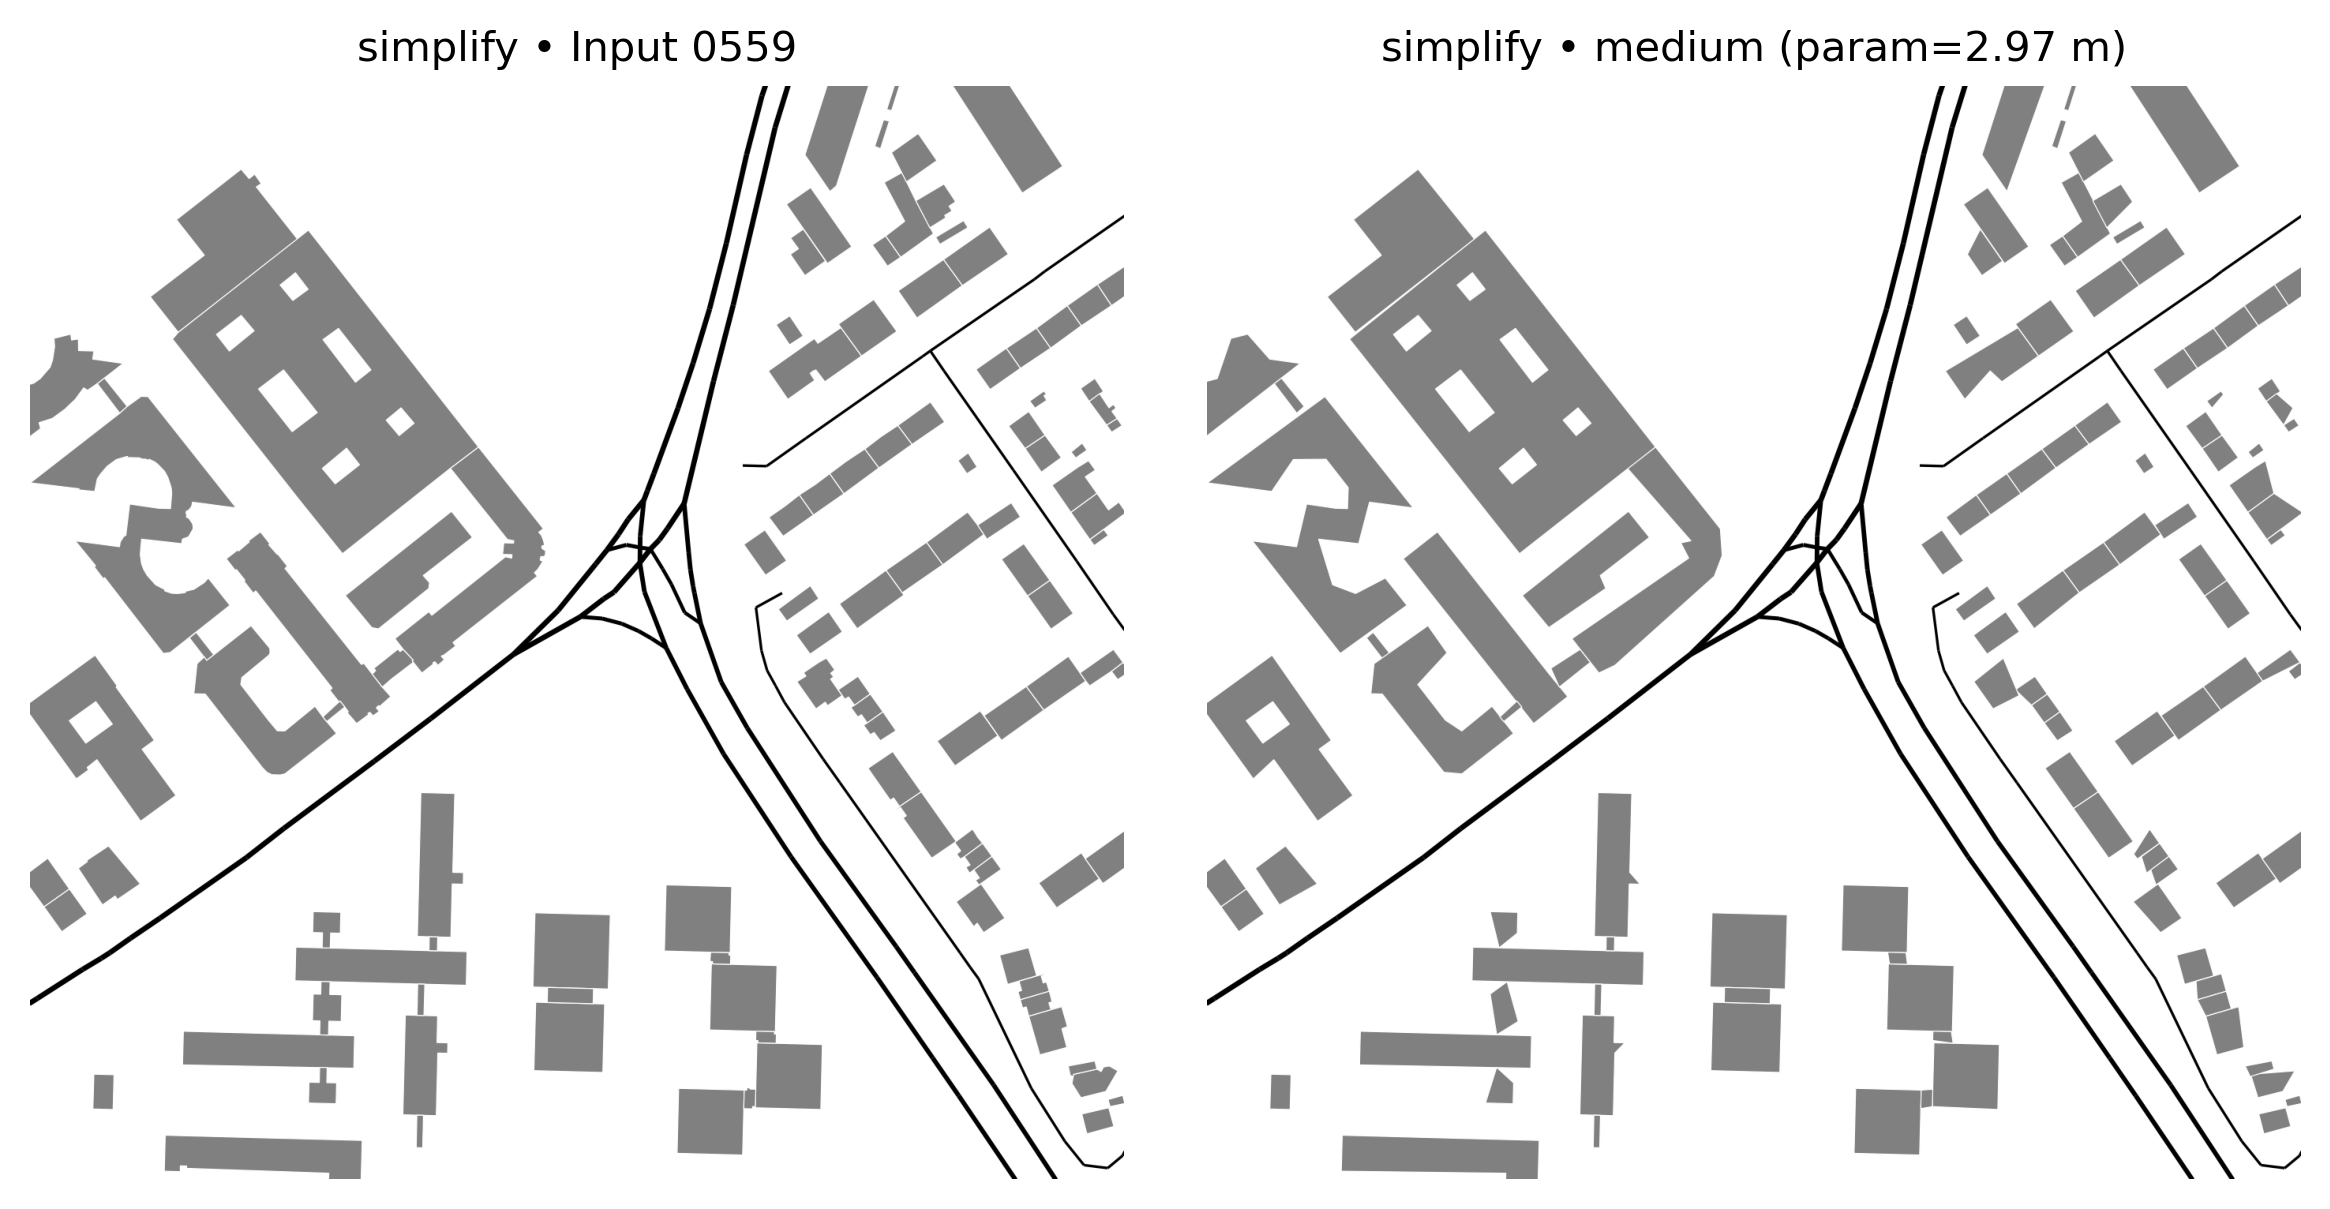

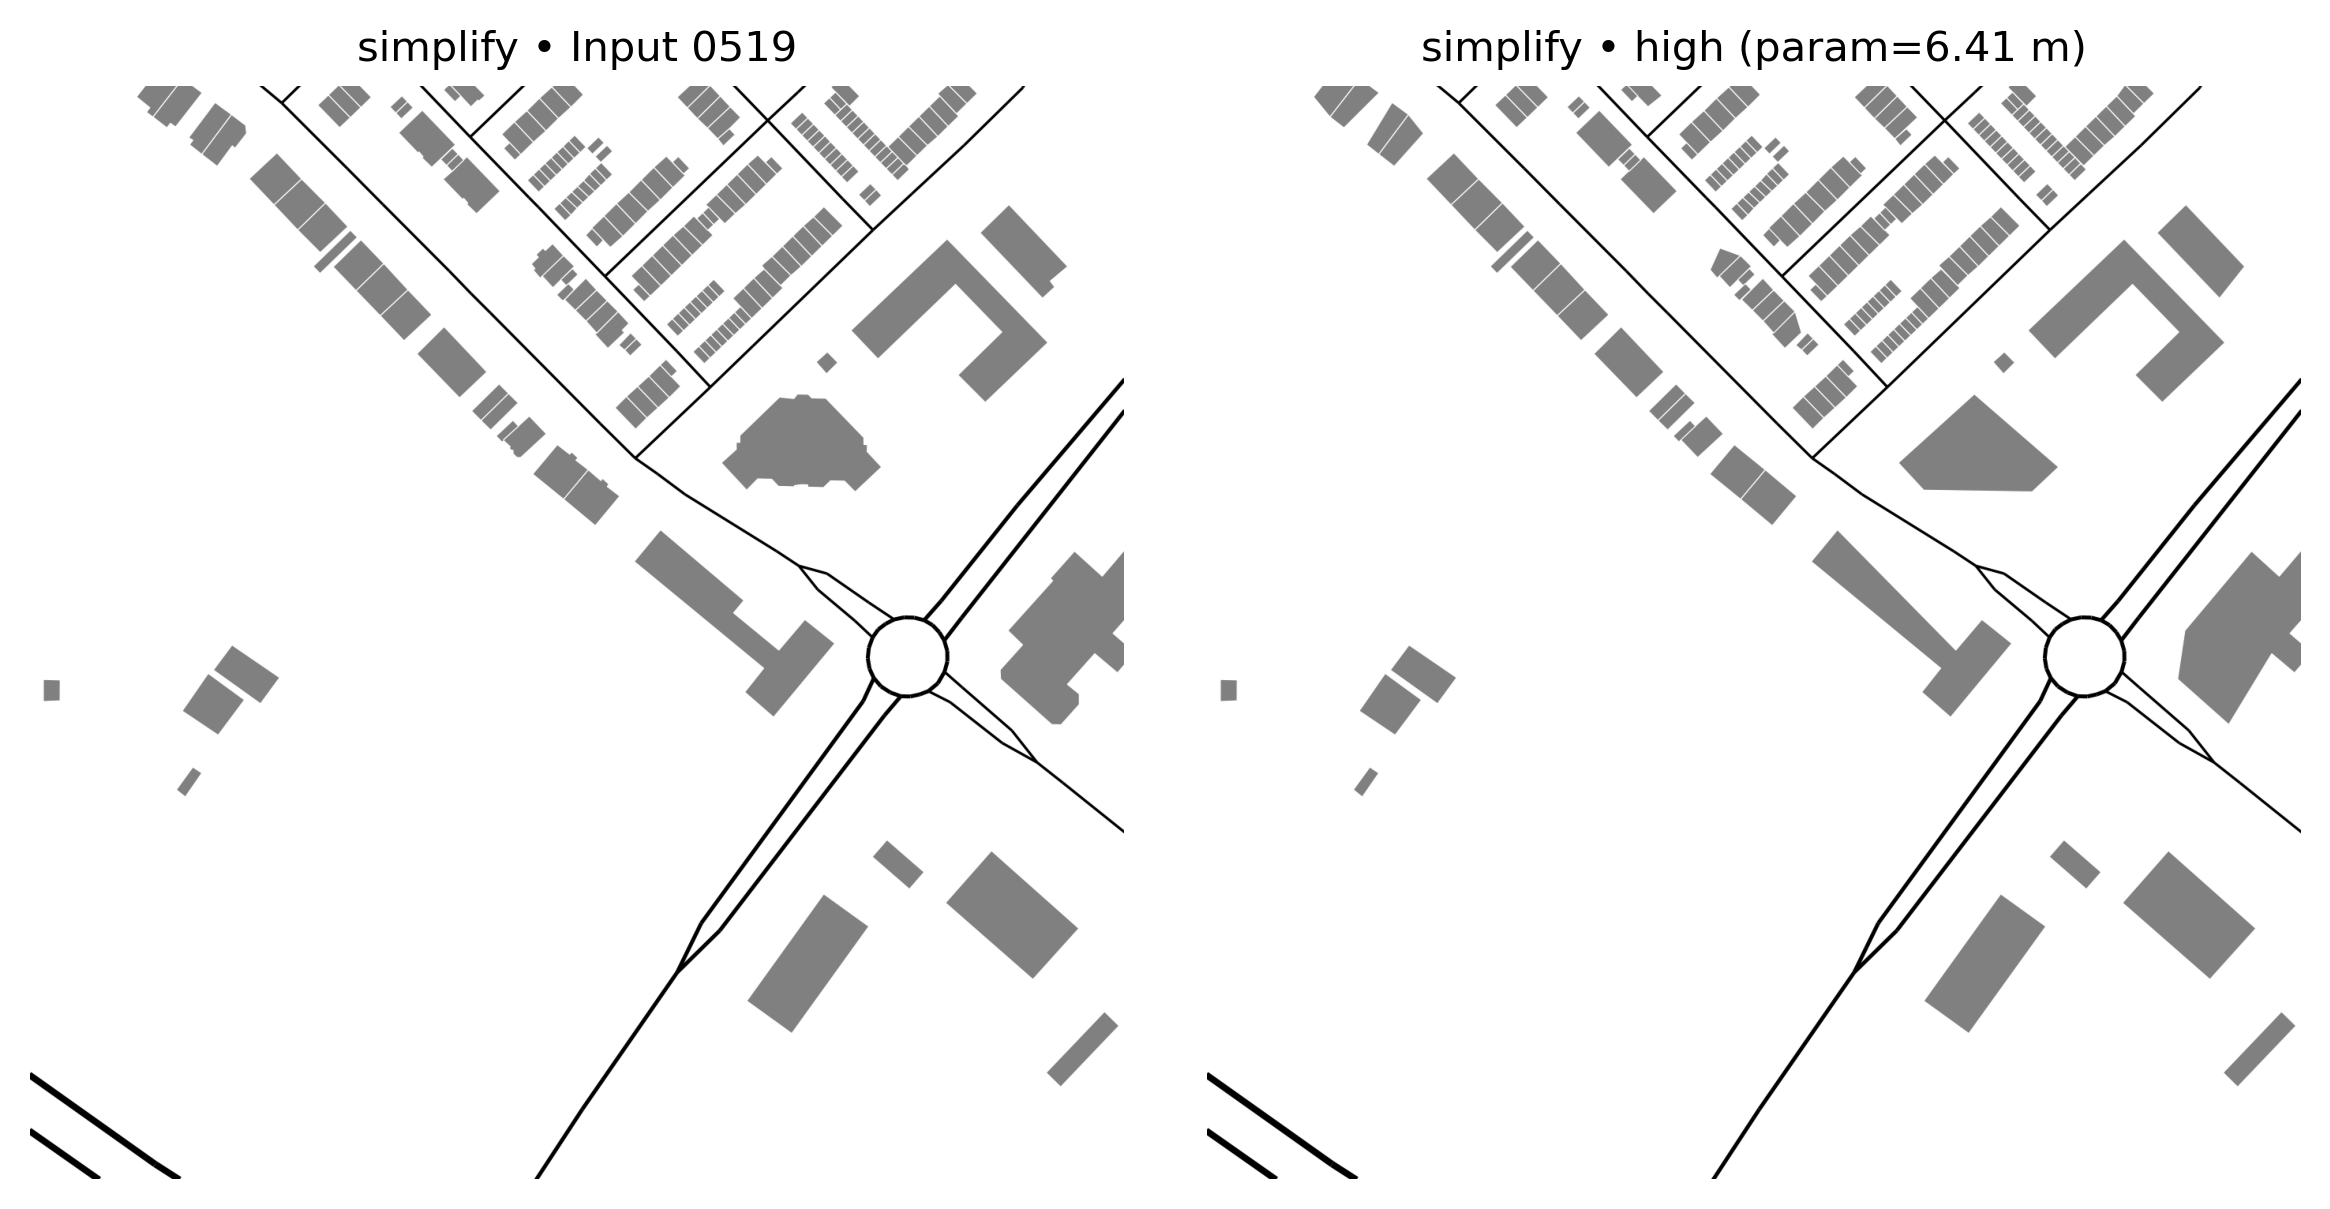

Saved 12 summary images to /Users/amirdonyadide/Documents/GitHub/Thesis/data/input/samples/samples_summary_new


In [24]:
# === Make exactly 1 pair per (operator, intensity), using the saved PNGs ===
# It picks the sample whose parameter is closest to the median in that group (more "representative").
# Ensure PNG paths exist in meta_df (reconstruct if needed)
if not {"input_png","target_png"}.issubset(meta_df.columns):
    def _png_paths_from_id(sid):
        sid4 = f"{int(sid):04d}"
        base = Path("data/samples") / sid4
        return str(base / f"input_{sid4}.png"), str(base / f"generalized_{sid4}.png")
    meta_df = meta_df.copy()
    meta_df["input_png"], meta_df["target_png"] = zip(*meta_df["sample_id"].map(_png_paths_from_id))

ops = sorted(meta_df["operator"].unique())
levels = ["low","medium","high"]

summary_dir.mkdir(parents=True, exist_ok=True)

chosen_rows = []

for op in ops:
    for lvl in levels:
        group = meta_df[(meta_df["operator"] == op) & (meta_df["intensity"] == lvl)].copy()
        if group.empty:
            print(f"Skip: no data for ({op}, {lvl})")
            continue
        # choose the sample with parameter closest to the group's median
        med = group["param_value"].median()
        idx = (group["param_value"] - med).abs().idxmin()
        row = group.loc[idx]
        chosen_rows.append(row)

        sid = int(row["sample_id"])
        in_png  = row["input_png"]
        out_png = row["target_png"]

        # make a side-by-side figure (same DPI as saved PNGs is fine; we set display dpi to 300)
        fig, axes = plt.subplots(1, 2, figsize=(8, 4), dpi=300)
        for a in axes: a.set_axis_off()

        try:
            im_in  = plt.imread(in_png)
            im_out = plt.imread(out_png)
        except FileNotFoundError:
            axes[0].text(0.5, 0.5, f"Missing {sid:04d}", ha="center", va="center")
            axes[1].text(0.5, 0.5, f"Missing {sid:04d}", ha="center", va="center")
            plt.tight_layout()
            plt.show()
            continue

        axes[0].imshow(im_in)
        axes[0].set_title(f"{op} • Input {sid:04d}", fontsize=10)

        axes[1].imshow(im_out)
        axes[1].set_title(f"{op} • {lvl} (param={row['param_value']:.2f} {row['param_unit']})", fontsize=10)

        plt.tight_layout()

        # save one image per (operator, intensity)
        out_path = summary_dir / f"{op}_{lvl}.png"
        plt.savefig(out_path, dpi=300, bbox_inches="tight", pad_inches=0)
        plt.show()

print(f"Saved {len(chosen_rows)} summary images to {summary_dir.resolve()}")